# Лабораторная работа №1

## Сравнительный анализ качества модели CatBoost при обучении без понижения размерности и с применением Kernel PCA
---

- В качестве примера задачи машинного обучения была выбрана задача из лабораторной работы 2. — разработка и оценка классификатора, прогнозирующего вероятность прекращения сотрудничества клиента с банком;
- Цель работы - достижение значения метрики F1 не ниже 0.59 на тестовом наборе данных. Для дополнительной оценки качества модели используется метрика ROC AUC;

## Была заранее выполнена следующая предобработка данных

### 1. Предобработка данных

- **Проверка соответствия типов данных**  
- **Обработка пропущенных значений**  
- **Обработка дубликатов**
- **Обработка аномальных значений и выбросов**  
- **Кодирование категориальных признаков**  
- **Скалирование / нормализация данных**  

### 2. Создание новых признаков

### 3. Оценка влияния признаков

- Анализ корреляций и значимости признаков.  
- Отбор наиболее значимых признаков на основе статистических критериев и моделей.  

### 4. Борьба с дисбалансом с применением Tomek Links, Сlass Weight, а так же подбором пороговога значения предсказания того или инного класса.

> Распределение таргетного признака до обработки

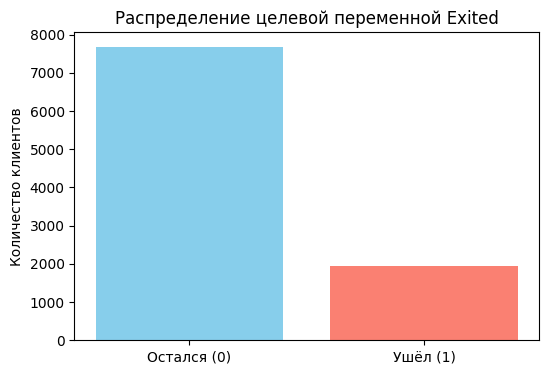

> Распределение таргетного признака после обработки

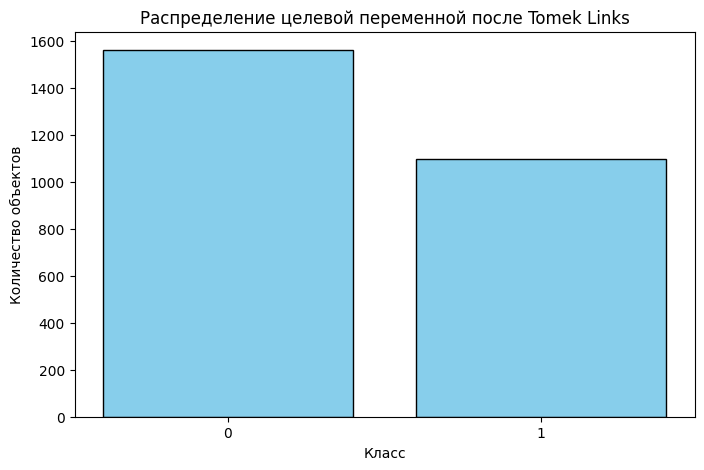

> Распределение данных классов после применения разных методов борьбы с дисбалансом.

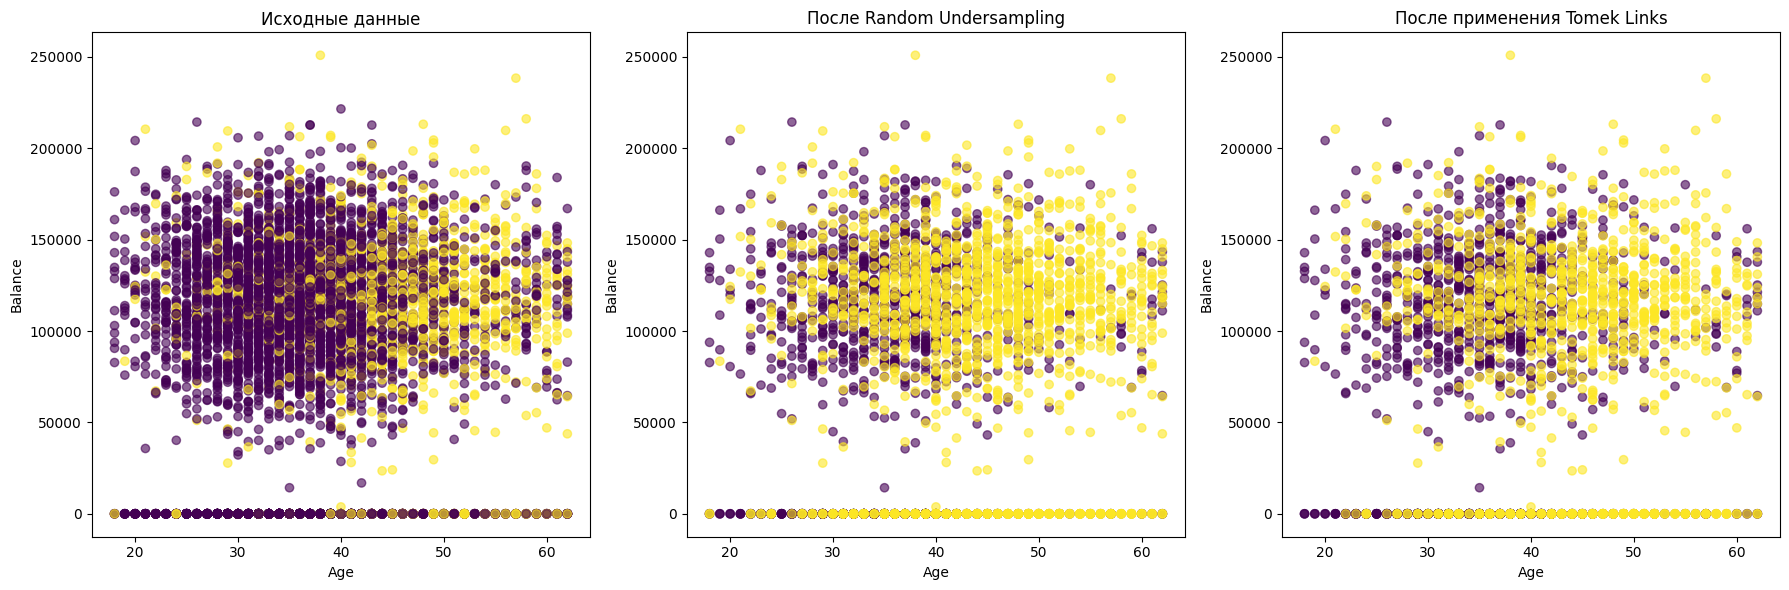

## 1. Подготовка данных

---

Установка модели:

In [1]:
pip install catboost -q

Note: you may need to restart the kernel to use updated packages.


Импорты:

In [2]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from math import sqrt
from copy import deepcopy
from math import copysign
from math import exp, tanh
from numbers import Number
from itertools import product
from numba import njit, prange
from typing import Tuple, Union
from __future__ import annotations
from typing import Iterable, Callable
from catboost import CatBoostClassifier


from IPython.display import display, Markdown
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from typing import List, Tuple, Iterable, Union, Any
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report, roc_curve

Загружаем готовые сбалансированные данные:

In [3]:
pip install joblib==1.2.0


Note: you may need to restart the kernel to use updated packages.


In [4]:
import joblib

X_res_final_loaded = joblib.load("data/X_res_final.joblib")
y_res_final_loaded = joblib.load("data/y_res_final.joblib")

X_train_loaded = joblib.load("data/X_train.joblib")
X_test_loaded  = joblib.load("data/X_test.joblib")
y_train_loaded = joblib.load("data/y_train.joblib")
y_test_loaded  = joblib.load("data/y_test.joblib")

print(f"X_res_final_loaded shape: {X_res_final_loaded.shape}")
print(f"y_res_final_loaded shape: {len(y_res_final_loaded)}")


X_res_final_loaded shape: (2888, 10)
y_res_final_loaded shape: 2888


## 1. Обучение CatBoost без применения PCA
---

Перед началом обучения построим корреляционную матрицу, в рамках дополнительного анализа и попытки понять насколько сильно признаки связаны друг с другом:

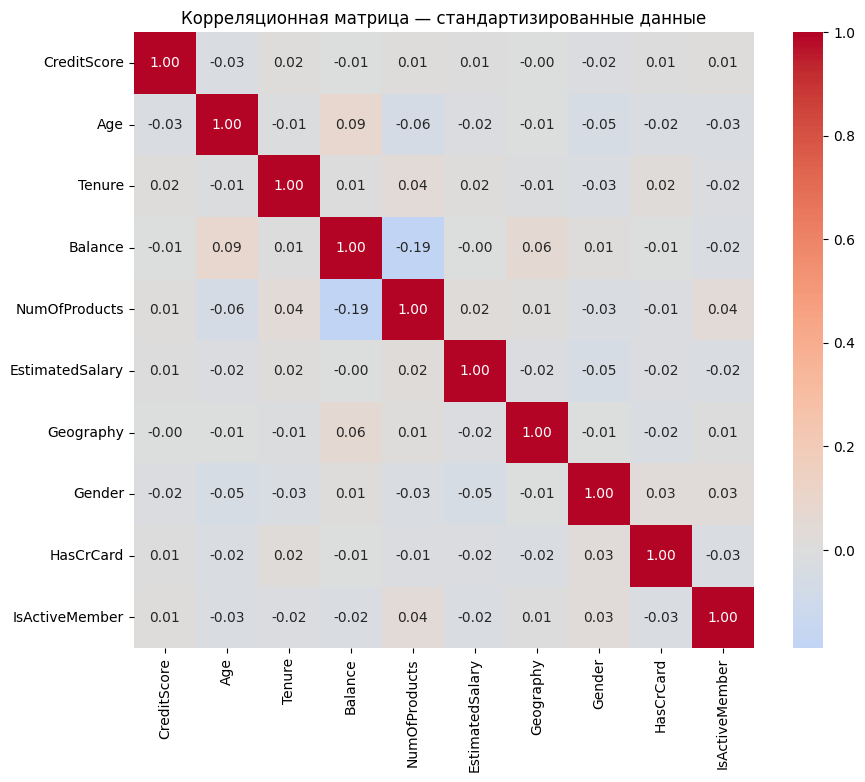

In [5]:
# Выбираем только числовые признаки
num_cols = X_res_final_loaded.select_dtypes(include=['float64', 'int64', 'int8']).columns

# Стандартизируем
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_res_final_loaded[num_cols]), columns=num_cols)

# Корреляционная матрица после стандартизации
corr_scaled = X_scaled.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_scaled, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Корреляционная матрица — стандартизированные данные")
plt.show()

### Промежуточный вывод по матрице корреляции для датасета **X_res_final_loaded**
---

- Признаки в исходном наборе практически независимы, линейная зависимость выражена слабо;
- При переходе к **PCA** или **Kernel PCA**, данные будут преобразованы в новые компоненты, которые будут ещё менее коррелированы;

---

Теперь выполним обучение модели **CatBoostClassifier** на сбалансированных данных (**X_res_final, y_res_final**) без использования методов снижения размерности. 

После обучения проводится оценка качества модели на тренировочной и тестовой выборках с использованием метрик **Accuracy**, **F1**, **ROC AUC**, а также строится ROC-кривая для визуального анализа различий между **train** и **test**:

=== CatBoost ===
Train metrics:
              precision    recall  f1-score   support

           0      0.868     0.816     0.841      1560
           1      0.798     0.854     0.825      1328

    accuracy                          0.833      2888
   macro avg      0.833     0.835     0.833      2888
weighted avg      0.836     0.833     0.834      2888

Test metrics:
              precision    recall  f1-score   support

           0      0.927     0.811     0.865      1536
           1      0.501     0.749     0.600       390

    accuracy                          0.798      1926
   macro avg      0.714     0.780     0.733      1926
weighted avg      0.841     0.798     0.811      1926

Train: Accuracy=0.833, F1=0.825, ROC AUC=0.919
Test: Accuracy=0.798, F1=0.600, ROC AUC=0.858


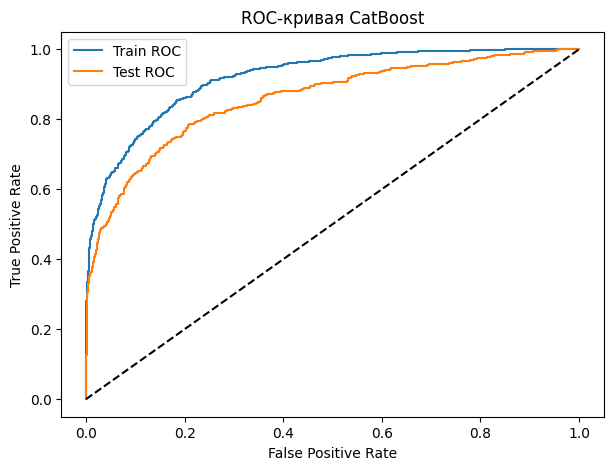

In [6]:
# --- Модель ---
cat_model = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.0005,
    depth=6,
    l2_leaf_reg=3,
    class_weights=[0.7, 1.0],
    random_seed=42,
    verbose=False
)

# --- Обучение ---
cat_model.fit(X_res_final_loaded, y_res_final_loaded)

# --- Предсказания ---
y_train_pred = cat_model.predict(X_res_final_loaded)
y_train_proba = cat_model.predict_proba(X_res_final_loaded)[:, 1]
y_test_pred = cat_model.predict(X_test_loaded)
y_test_proba = cat_model.predict_proba(X_test_loaded)[:, 1]

# --- Метрики ---
print("=== CatBoost ===")
print("Train metrics:")
print(classification_report(y_res_final_loaded, y_train_pred, digits=3))
print("Test metrics:")
print(classification_report(y_test_loaded, y_test_pred, digits=3))

print(f"Train: Accuracy={accuracy_score(y_res_final_loaded, y_train_pred):.3f}, "
      f"F1={f1_score(y_res_final_loaded, y_train_pred):.3f}, "
      f"ROC AUC={roc_auc_score(y_res_final_loaded, y_train_proba):.3f}")
print(f"Test: Accuracy={accuracy_score(y_test_loaded, y_test_pred):.3f}, "
      f"F1={f1_score(y_test_loaded, y_test_pred):.3f}, "
      f"ROC AUC={roc_auc_score(y_test_loaded, y_test_proba):.3f}")

# --- ROC-кривая ---
fpr_train, tpr_train, _ = roc_curve(y_res_final_loaded, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test_loaded, y_test_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr_train, tpr_train, label='Train ROC')
plt.plot(fpr_test, tpr_test, label='Test ROC')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC-кривая CatBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Реализуем поиск оптимальных гиперпараметров модели CatBoost с помощью полного перебора (Grid Search) по заранее заданным диапазонам параметров:
- **количество итераций**;
- **скорость обучения** (learning_rate);
- **глубина деревьев**;
- **коэффициент регуляризации** (l2_leaf_reg);
- **веса классов** (class_weights);
    
Для каждой комбинации параметров модель обучается и оценивается по метрикам F1, Accuracy, ROC AUC.
По итогам подбираются лучшие параметры модели, обеспечивающие максимальное значение F1-меры на тестовой выборке:

In [ ]:
# --- Базовые параметры ---
base_params = {
    'iterations': 5000,
    'learning_rate': 0.0005,
    'depth': 6,
    'l2_leaf_reg': 3,
    'class_weights': [0.7, 1.0],
    'random_seed': 42,
    'verbose': False,
    'eval_metric': 'F1',
}

# --- Локальные диапазоны ---
param_grid = {
    'iterations': [4500, 5000, 5500],
    'learning_rate': [0.0003, 0.0005, 0.0007],
    'depth': [5, 6, 7],
    'l2_leaf_reg': [2, 3, 4],
    'class_weights': [
        [0.6, 1.0],
        [0.7, 1.0],
        [0.8, 1.0]
    ]
}

# --- Генерация комбинаций ---
param_combinations = list(product(
    param_grid['iterations'],
    param_grid['learning_rate'],
    param_grid['depth'],
    param_grid['l2_leaf_reg'],
    param_grid['class_weights']
))

print(f"Всего комбинаций: {len(param_combinations)}")

best_model = None
best_f1 = -1
best_params = None

# --- Основной цикл ---
for iterations, lr, depth, l2, weights in tqdm(param_combinations, desc="Локальный поиск"):
    params = base_params.copy()
    params.update({
        'iterations': iterations,
        'learning_rate': lr,
        'depth': depth,
        'l2_leaf_reg': l2,
        'class_weights': weights
    })

    model = CatBoostClassifier(**params)
    model.fit(X_train_loaded, y_train_loaded, eval_set=(X_test_loaded, y_test_loaded), use_best_model=True, verbose=False)

    y_pred = model.predict(X_test_loaded)
    y_proba = model.predict_proba(X_test_loaded)[:, 1]

    f1 = f1_score(y_test_loaded, y_pred)
    acc = accuracy_score(y_test_loaded, y_pred)
    roc_auc = roc_auc_score(y_test_loaded, y_proba)

    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_params = params

# --- Итоги ---
print("🏆 Лучшая модель:")
print(f"Параметры: {best_params}")
print(f"F1: {best_f1:.3f}")

## Вывод по результатам модели CatBoost без применения PCA
---

В результате локального подбора гиперпараметров методом полного перебора (Grid Search) было протестировано 243 комбинации параметров. Достигнутое значение метрики F1 = 0.640 на тестовой выборке превышает установленный минимальный порог (F1 ≥ 0.59), следовательно, требование к качеству модели выполнено.

Однако значение F1 нельзя считать высоким — модель демонстрирует умеренное качество классификации, способности CatBoost ограничены без дополнительной обработки признаков (например, PCA), модель не улавливливает сложные зависимости в данных.

## 2. Применение PCA и обучение CatBoost на преобразованных данных
---

На втором этапе проводится обучение модели CatBoost на данных, предварительно преобразованных с помощью метода главных компонент (PCA).

Основная цель данного эксперимента — проверить, улучшится ли качество классификации (в частности, метрика F1) по сравнению с базовой моделью, обученной без использования PCA. Первым делом реализуем главные вспомогательные функции для примения метода главных компонент.

---

1. Реализуем вспомогательные функции для вычисления скалярного произведения, евклидовой нормы и знака числа — базовые операции, необходимые для QR-разложения:

In [8]:
def prod_scalar(vector_a: Iterable[Number], vector_b: Iterable[Number]) -> float:

    if len(vector_a) != len(vector_b):
        raise ValueError("Длины векторов должны совпадать для скалярного произведения")
    return float(sum(float(a) * float(b) for a, b in zip(vector_a, vector_b)))


def euclidean_norm(vector: Iterable[Number]) -> float:
    return (prod_scalar(vector, vector))**0.5


def sign(value: float) -> float:

    return 1.0 if value == 0.0 else copysign(1.0, value)

2. Создадим собственный класс **Matrix**, обеспечивающий работу с матрицами -
сложение, вычитание, умножение, транспонирование, норму, диагональ и другие операции.
Реализована строгая проверка размерностей и поддержка как чисел, так и других матриц:

In [9]:
Number = Union[int, float]


class Matrix:
    def __init__(self, values: Iterable[Iterable[Number]]) -> None:
        if (
            not values
            or not isinstance(values, (list, tuple))
            or not isinstance(values[0], (list, tuple))
        ):
            raise ValueError("Данные матрицы должны быть непустым списком списков")

        row_count: int = len(values)
        col_count: int = len(values[0])

        for row in values:
            if len(row) != col_count:
                raise ValueError("Все строки матрицы должны иметь одинаковую длину")

        self._values: List[List[float]] = [
            [float(element) for element in row] for row in values
        ]
        self._row_count: int = row_count
        self._col_count: int = col_count

    @staticmethod
    def zeros(row_count: int, col_count: int) -> "Matrix":
        return Matrix([[0.0] * col_count for _ in range(row_count)])

    @staticmethod
    def eye(size: int) -> "Matrix":
        identity = Matrix.zeros(size, size)
        for index in range(size):
            identity._values[index][index] = 1.0
        return identity

    @property
    def shape(self) -> Tuple[int, int]:
        return self._row_count, self._col_count

    def copy(self) -> "Matrix":
        return Matrix(deepcopy(self._values))

    def is_square(self) -> bool:
        return self._row_count == self._col_count

    def is_symmetric(self, tolerance: float = 1e-12) -> bool:
        if not self.is_square():
            return False
        size: int = self._row_count
        for row_index in range(size):
            for col_index in range(row_index + 1, size):
                if abs(self._values[row_index][col_index] - self._values[col_index][row_index]) > tolerance:
                    return False
        return True

    def __getitem__(self, row_index: int) -> List[float]:
        return self._values[row_index]

    def __setitem__(self, row_index: int, new_row: Iterable[Number]) -> None:

        if len(new_row) != self._col_count:
            raise ValueError("Длина строки не совпадает с числом столбцов")

        self._values[row_index] = [float(element) for element in new_row]

    def __add__(self, other: Union["Matrix", Number]) -> "Matrix":
        if isinstance(other, Matrix):
            self_rows, self_cols = self.shape
            other_rows, other_cols = other.shape
            if (self_rows, self_cols) != (other_rows, other_cols):
                raise ValueError("Размеры матриц не совпадают для сложения")
            return Matrix(
                [
                    [self._values[row_index][col_index] + other._values[row_index][col_index] for col_index in range(self_cols)]
                    for row_index in range(self_rows)
                ]
            )
        elif isinstance(other, (int, float)):
            self_rows, self_cols = self.shape
            return Matrix(
                [
                    [self._values[row_index][col_index] + float(other) for col_index in range(self_cols)]
                    for row_index in range(self_rows)
                ]
            )
        else:
            raise TypeError("Поддерживается сложение только с Matrix или числом")

    def __sub__(self, other: Union["Matrix", Number]) -> "Matrix":
        if isinstance(other, Matrix):
            self_rows, self_cols = self.shape
            other_rows, other_cols = other.shape
            if (self_rows, self_cols) != (other_rows, other_cols):
                raise ValueError("Размеры матриц не совпадают для вычитания")
            return Matrix(
                [
                    [self._values[row_index][col_index] - other._values[row_index][col_index] for col_index in range(self_cols)]
                    for row_index in range(self_rows)
                ]
            )
        elif isinstance(other, (int, float)):
            self_rows, self_cols = self.shape
            return Matrix(
                [
                    [self._values[row_index][col_index] - float(other) for col_index in range(self_cols)]
                    for row_index in range(self_rows)
                ]
            )
        else:
            raise TypeError("Поддерживается вычитание только с Matrix или числом")

    def __rmul__(self, other: Number) -> "Matrix":
        return self.__mul__(other)

    def __mul__(self, other: Union["Matrix", Number]) -> "Matrix":
        if isinstance(other, (int, float)):
            row_count, col_count = self.shape
            factor = float(other)
            return Matrix(
                [
                    [self._values[row_index][col_index] * factor for col_index in range(col_count)]
                    for row_index in range(row_count)
                ]
            )
        elif isinstance(other, Matrix):
            left_rows, left_cols = self.shape
            right_rows, right_cols = other.shape
            if left_cols != right_rows:
                raise ValueError("Формы матриц несовместимы для умножения")
            result = Matrix.zeros(left_rows, right_cols)
            for row_index in range(left_rows):
                for common_index in range(left_cols):
                    left_value = self._values[row_index][common_index]
                    if left_value == 0.0:
                        continue
                    result_row = result._values[row_index]
                    other_row = other._values[common_index]
                    for col_index in range(right_cols):
                        result_row[col_index] += left_value * other_row[col_index]
            return result
        else:
            raise TypeError("Поддерживается умножение только с Matrix или числом")

    def transposed(self) -> "Matrix":
        row_count, col_count = self.shape
        return Matrix([[self._values[row_index][col_index] for row_index in range(row_count)] for col_index in range(col_count)])

    @staticmethod
    def outer(vector_left: Iterable[Number], vector_right: Iterable[Number]) -> "Matrix":
        return Matrix(
            [
                [float(vector_left[row_index]) * float(vector_right[col_index]) for col_index in range(len(vector_right))]
                for row_index in range(len(vector_left))
            ]
        )

    def norm(self) -> float:
        squared_sum: float = 0.0
        for row in self._values:
            for value in row:
                squared_sum += value * value
        return sqrt(squared_sum)

    def diagonal(self) -> List[float]:
        if not self.is_square():
            raise ValueError("Диагональ определена только для квадратных матриц")
        return [self._values[index][index] for index in range(self._row_count)]

    def __repr__(self) -> str:
        return str(self)

    def __str__(self) -> str:
        formatted_rows: List[str] = []
        for row in self._values:
            formatted_rows.append("[" + "  ".join(f"{value: .6g}" for value in row) + "]")
        return "\n".join(formatted_rows)

3. Реализация QR-разложения и QR-алгоритма:

In [10]:
def qr_decomposition_householder(matrix: "Matrix") -> Tuple["Matrix", "Matrix"]:
    """
    QR-разложение матрицы методом отражений Хаусхолдера

    :return: tuple(Q, R), где Q — (n x n), R — (n x m).
    """

    r_matrix: Matrix = matrix.copy()
    row_count, col_count = r_matrix.shape
    q_matrix: Matrix = Matrix.eye(row_count)

    for pivot_index in range(min(row_count, col_count) - 1):
        # Берём столбец pivot_index, начиная с строки pivot_index
        column_tail: list[float] = [r_matrix[row_index][pivot_index] for row_index in range(pivot_index, row_count)]
        column_tail_norm: float = euclidean_norm(column_tail)
        if column_tail_norm == 0.0:
            continue

        unit_first: list[float] = [0.0] * (row_count - pivot_index)
        unit_first[0] = 1.0

        alpha_value: float = sign(column_tail[0]) * column_tail_norm

        # u = x + alpha * e1
        householder_raw: list[float] = [
            column_tail[idx] + alpha_value * unit_first[idx] for idx in range(row_count - pivot_index)
        ]
        householder_norm: float = euclidean_norm(householder_raw)
        if householder_norm == 0.0:
            continue

        # v = u / ||u||
        householder_vector: list[float] = [component / householder_norm for component in householder_raw]

        reflector_full: list[float] = [0.0] * row_count
        for local_index, value in enumerate(householder_vector):
            reflector_full[pivot_index + local_index] = value

        # Матрица отражения H = I - 2 * v v^T
        identity_matrix: Matrix = Matrix.eye(row_count)
        outer_product: Matrix = Matrix.outer(reflector_full, reflector_full)
        householder_matrix: Matrix = identity_matrix - (2.0 * outer_product)

        r_matrix = householder_matrix * r_matrix
        q_matrix = q_matrix * householder_matrix

    return q_matrix, r_matrix


def qr_algorithm(
    matrix: "Matrix",
    max_iterations: int = 1000,
    tolerance: float = 1e-12,
    return_eigenvectors: bool = False
) -> Tuple[list[float], Matrix | None]:
    """
    QR-алгоритм без сдвигов для приближённого нахождения собственных значений
    """
    if not matrix.is_square():
        raise ValueError("QR-алгоритм требует квадратную матрицу")

    size, _ = matrix.shape
    iterated_matrix: Matrix = matrix.copy()
    eigenvectors_matrix: Matrix = Matrix.eye(size)

    for _iteration_index in range(max_iterations):
        q_matrix, r_matrix = qr_decomposition_householder(iterated_matrix)
        iterated_matrix = r_matrix * q_matrix

        eigenvectors_matrix = eigenvectors_matrix * q_matrix

        sum_of_squares_offdiag: float = 0.0
        for row_index in range(size):
            for col_index in range(0, row_index):
                value = iterated_matrix[row_index][col_index]
                sum_of_squares_offdiag += value * value
        offdiag_norm: float = sum_of_squares_offdiag**0.5
        if offdiag_norm < tolerance:
            break

    eigenvalues: list[float] = iterated_matrix.diagonal()

    if return_eigenvectors and matrix.is_symmetric():
        normalized_vectors: Matrix = eigenvectors_matrix.copy()
        for col_index in range(size):
            column_values: list[float] = [normalized_vectors[row_index][col_index] for row_index in range(size)]
            column_norm: float = euclidean_norm(column_values)
            if column_norm != 0.0:
                inv_norm: float = 1.0 / column_norm
                for row_index in range(size):
                    normalized_vectors[row_index][col_index] *= inv_norm
        return eigenvalues, normalized_vectors

    return eigenvalues, None

4. Тестирование QR-алгоритма:

In [11]:
if __name__ == "__main__":
    A = Matrix([
        [4.0, 1.0, 1.0],
        [1.0, 3.0, 0.0],
        [1.0, 0.0, 2.0],
    ])

    vals, _ = qr_algorithm(A)
    print("Eigenvectors:", vals)

    vals2, vecs = qr_algorithm(A, return_eigenvectors=True)
    print("Eigenvalues (sym):", vals)
    print("Eigenvectors (columns):\n", vecs)

Eigenvectors: [4.87938524157182, 2.6527036446661287, 1.4679111137620435]
Eigenvalues (sym): [4.87938524157182, 2.6527036446661287, 1.4679111137620435]
Eigenvectors (columns):
 [-0.84403   0.293128  -0.449099]
[-0.449099  -0.84403   0.293128]
[-0.293128   0.449099   0.84403]


5. Реализация **PCA** через QR-алгоритм:

In [12]:
# 1. Центрирование данных (списки списков)
def center_data(X):
    n_rows = len(X)
    n_cols = len(X[0])
    means = [sum(X[i][j] for i in range(n_rows))/n_rows for j in range(n_cols)]
    X_centered = [[X[i][j] - means[j] for j in range(n_cols)] for i in range(n_rows)]
    return X_centered, means

# 2. Ковариационная матрица
def covariance_matrix(X_centered):
    n_rows = len(X_centered)
    n_cols = len(X_centered[0])
    cov = [[0.0]*n_cols for _ in range(n_cols)]
    for i in range(n_cols):
        for j in range(n_cols):
            s = sum(X_centered[k][i] * X_centered[k][j] for k in range(n_rows))
            cov[i][j] = s / (n_rows - 1)
    return cov

# 3. Применение qr_algorithm
def pca_qr(X):
    X_centered, means = center_data(X)
    cov = covariance_matrix(X_centered)
    A = Matrix(cov)

    # Получаем собственные значения и векторы
    eigvals, eigvecs = qr_algorithm(A, return_eigenvectors=True)

    # Доля объяснённой дисперсии
    total_variance = sum(eigvals)
    explained_ratio = [v / total_variance for v in eigvals]

    # Преобразование данных в главные компоненты
    # X_pca = X_centered @ eigvecs (на списках)
    n_rows = len(X_centered)
    n_cols = len(X_centered[0])
    X_pca = [[sum(X_centered[i][k] * eigvecs[k][j] for k in range(n_cols))
              for j in range(n_cols)] for i in range(n_rows)]

    return eigvals, eigvecs, explained_ratio, X_pca

6. Применение PCA к обучающему набору:

In [13]:
# Преобразуем DataFrame в список списков
X_list = X_res_final_loaded.values.tolist()

# Центрирование
X_centered, means = center_data(X_list)

# Ковариация
cov = covariance_matrix(X_centered)

# QR-алгоритм
A = Matrix(cov)
eigvals, eigvecs = qr_algorithm(A, return_eigenvectors=True)

# Объяснённая дисперсия
total_var = sum(eigvals)
explained_ratio = [v / total_var for v in eigvals]

# Проекция на главные компоненты
n_rows = len(X_centered)
n_cols = len(X_centered[0])
X_pca = [[sum(X_centered[i][k] * eigvecs[k][j] for k in range(n_cols))
          for j in range(n_cols)] for i in range(n_rows)]

Также построим матрицу корреляции для данных после применения **PCA**:

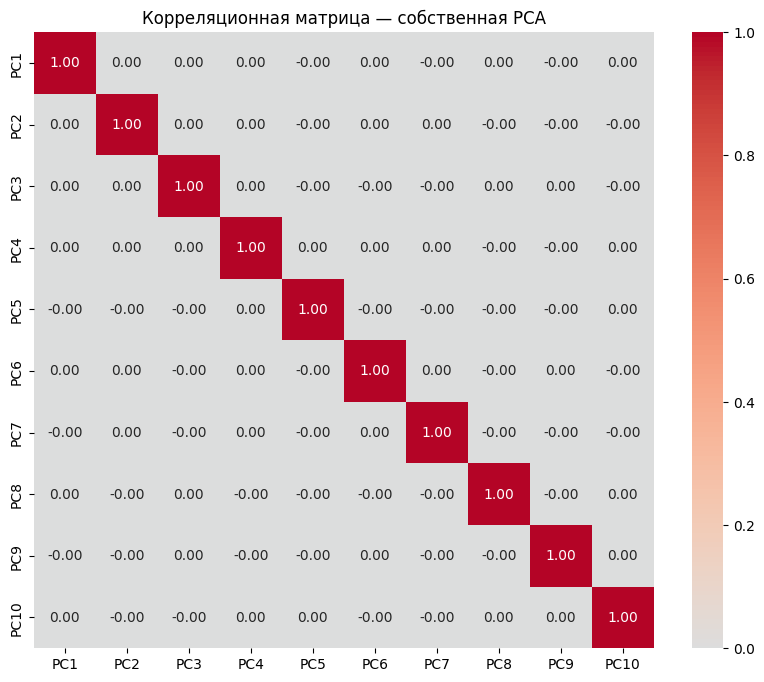

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
PC1,1.000000e+00,1.248213e-16,1.774780e-16,4.222031e-17,-4.876387e-17,8.219470e-17,-2.061997e-16,2.941733e-17,-1.723700e-17,1.105642e-17
PC2,1.248213e-16,1.000000e+00,7.033204e-16,9.527491e-17,-7.673653e-16,4.186793e-17,5.908650e-17,-6.920356e-17,-6.859592e-17,-1.677529e-18
PC3,1.774780e-16,7.033204e-16,1.000000e+00,1.471827e-15,-7.974576e-16,-1.045748e-16,-6.074928e-17,2.224017e-17,1.548162e-16,-7.281890e-17
PC4,4.222031e-17,9.527491e-17,1.471827e-15,1.000000e+00,1.926306e-15,3.193164e-16,2.355315e-16,-1.545121e-16,-1.442293e-18,1.561103e-16
PC5,-4.876387e-17,-7.673653e-16,-7.974576e-16,1.926306e-15,1.000000e+00,-2.633976e-19,-4.764709e-17,-3.634866e-16,-1.004245e-15,3.525438e-16
PC6,8.219470e-17,4.186793e-17,-1.045748e-16,3.193164e-16,-2.633976e-19,1.000000e+00,5.273813e-16,-7.465807e-17,8.283468e-17,-7.503942e-17
PC7,-2.061997e-16,5.908650e-17,-6.074928e-17,2.355315e-16,-4.764709e-17,5.273813e-16,1.000000e+00,-3.995479e-12,-7.051551e-16,-6.024329e-17
PC8,2.941733e-17,-6.920356e-17,2.224017e-17,-1.545121e-16,-3.634866e-16,-7.465807e-17,-3.995479e-12,1.000000e+00,-4.732407e-16,9.931771e-16
PC9,-1.723700e-17,-6.859592e-17,1.548162e-16,-1.442293e-18,-1.004245e-15,8.283468e-17,-7.051551e-16,-4.732407e-16,1.000000e+00,1.001657e-15
PC10,1.105642e-17,-1.677529e-18,-7.281890e-17,1.561103e-16,3.525438e-16,-7.503942e-17,-6.024329e-17,9.931771e-16,1.001657e-15,1.000000e+00


In [14]:
# Преобразуем список списков в DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(len(X_pca[0]))])

# Матрица корреляций
corr_pca = X_pca_df.corr()

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(corr_pca, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Корреляционная матрица — собственная PCA")
plt.show()

corr_pca

### Промежуточный вывод по матрице корреляции для датасета **X_pca**
---
- Исходные данные имели небольшие, но заметные корреляции между признаками;
- После **PCA** компоненты стали почти идеально некоррелированными;
- **PCA** успешно разложил данные на независимые оси, и модель теперь работает с линейно независимыми признаками;

7. Преобразование PCA-результата в **DataFrame**:

In [15]:
# X_pca — это список списков, размерность (n_rows, n_cols)
n_cols = len(X_pca[0])

# Создаём имена колонок для главных компонент
pc_columns = [f'PC{i+1}' for i in range(n_cols)]

# Превращаем в DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=pc_columns)

# Если хочешь сохранить индексы исходного DataFrame
X_pca_df.index = X_res_final_loaded.index

# Проверка
display(X_pca_df.head())

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1.491170,0.771211,-0.226138,0.223127,0.133652,0.341611,0.032876,0.837899,-0.669721,-0.411934
1,-0.031961,-0.292322,1.058212,-0.536371,-0.092945,0.483493,-0.763056,0.282532,-0.403560,-0.560158
2,0.351726,0.790542,-0.554676,0.187483,-1.073341,-0.710273,-0.678822,0.106498,-0.286752,0.298096
3,-0.156325,-0.219457,-0.517396,0.661418,-0.064120,-1.035620,0.004486,-0.709180,-0.040232,0.105583
4,0.254924,-1.331309,1.097712,-0.236386,0.781233,-0.180639,-0.645583,0.194416,-0.688860,-0.490900


8. Обучение и оценка модели **CatBoost** на данных после **PCA**:


===== MODEL PERFORMANCE =====
Set            Accuracy    F1 Score    ROC AUC     
--------------------------------------------------
Train          0.817       0.809       0.918       
Validation     0.762       0.751       0.864       
Test           0.806       0.792       0.902       
--------------------------------------------------

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0      0.827     0.811     0.819       312
           1      0.783     0.801     0.792       266

    accuracy                          0.806       578
   macro avg      0.805     0.806     0.805       578
weighted avg      0.807     0.806     0.806       578



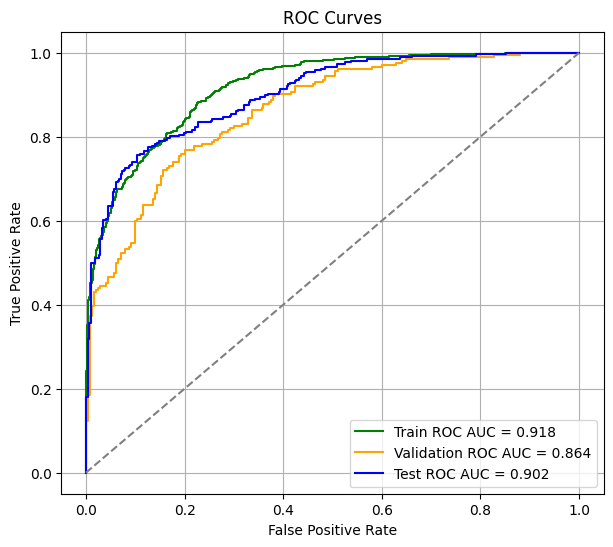


--- Prediction Distribution ---
Train predictions: 0    923
1    925
Name: count, dtype: int64
Val predictions: 0    232
1    230
Name: count, dtype: int64
Test predictions: 0    306
1    272
Name: count, dtype: int64

--- True Distribution ---
Train true: Exited
0    998
1    850
Name: count, dtype: int64
Val true: Exited
0    250
1    212
Name: count, dtype: int64
Test true: Exited
0    312
1    266
Name: count, dtype: int64


In [16]:
# --- Разделение на train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_df, y_res_final_loaded, test_size=0.2, random_state=42, stratify=y_res_final_loaded
)

# --- Делим тренировочные данные на train/validation ---
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# --- Обучение без вывода ---
cat_model.fit(X_train_split, y_train_split, eval_set=(X_val_split, y_val_split), verbose=0)

# --- Предсказания ---
y_proba_train = cat_model.predict_proba(X_train_split)[:, 1]
y_proba_val   = cat_model.predict_proba(X_val_split)[:, 1]
y_proba_test  = cat_model.predict_proba(X_test)[:, 1]

# --- Предсказания классов (стандартный порог 0.5) ---
y_pred_train = cat_model.predict(X_train_split)
y_pred_val   = cat_model.predict(X_val_split)
y_pred_test  = cat_model.predict(X_test)

# --- Функция для вывода метрик ---
def get_metrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_proba)
    }

# --- Считаем метрики ---
metrics_train = get_metrics(y_train_split, y_pred_train, y_proba_train)
metrics_val   = get_metrics(y_val_split, y_pred_val, y_proba_val)
metrics_test  = get_metrics(y_test, y_pred_test, y_proba_test)

# --- Печатаем метрики красиво ---
print("\n===== MODEL PERFORMANCE =====")
print(f"{'Set':<15}{'Accuracy':<12}{'F1 Score':<12}{'ROC AUC':<12}")
print("-" * 50)
print(f"{'Train':<15}{metrics_train['Accuracy']:<12.3f}{metrics_train['F1 Score']:<12.3f}{metrics_train['ROC AUC']:<12.3f}")
print(f"{'Validation':<15}{metrics_val['Accuracy']:<12.3f}{metrics_val['F1 Score']:<12.3f}{metrics_val['ROC AUC']:<12.3f}")
print(f"{'Test':<15}{metrics_test['Accuracy']:<12.3f}{metrics_test['F1 Score']:<12.3f}{metrics_test['ROC AUC']:<12.3f}")
print("-" * 50)

# --- Дополнительно выводим подробный classification_report ---
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred_test, digits=3))

# --- ROC-кривые ---
fpr_train, tpr_train, _ = roc_curve(y_train_split, y_proba_train)
fpr_val, tpr_val, _     = roc_curve(y_val_split, y_proba_val)
fpr_test, tpr_test, _   = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(7,6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC = {metrics_train["ROC AUC"]:.3f}', color='green')
plt.plot(fpr_val, tpr_val, label=f'Validation ROC AUC = {metrics_val["ROC AUC"]:.3f}', color='orange')
plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC = {metrics_test["ROC AUC"]:.3f}', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

# --- Проверка распределения предсказаний ---
print("\n--- Prediction Distribution ---")
print(f"Train predictions: {pd.Series(y_pred_train).value_counts().sort_index()}")
print(f"Val predictions: {pd.Series(y_pred_val).value_counts().sort_index()}")
print(f"Test predictions: {pd.Series(y_pred_test).value_counts().sort_index()}")

print("\n--- True Distribution ---")
print(f"Train true: {pd.Series(y_train_split).value_counts().sort_index()}")
print(f"Val true: {pd.Series(y_val_split).value_counts().sort_index()}")
print(f"Test true: {pd.Series(y_test).value_counts().sort_index()}")

## Вывод по результатам модели CatBoost с применения PCA
---

Применение **PCA** для предварительного преобразования признаков привело к значительному улучшению качества классификации.
Метрика **F1-score** выросла с 0.640 до 0.792 (видим огромный скачек в положительную сторону) - более точное и сбалансированное распознавание классов.

Кроме того, значения **ROC AUC** (0.902) и **Accuracy** (0.806) подтверждают, что модель с **PCA** лучше различает классы и обладает высокой обобщающей способностью.

## Промежуточный вывод
---

In [17]:
data = {
    "Модель": ["CatBoost без PCA", "CatBoost с PCA"],
    "F1 (Test)": [0.640, 0.792],
    "Accuracy (Test)": [0.875, 0.806],
    "ROC AUC (Test)": [0.897, 0.902],
    "Комментарий": [
        "Базовая модель, требование по F1 ≥ 0.59 выполнено, но качество умеренное.",
        "Существенное улучшение метрик, модель лучше улавливает сложные нелинейные зависимости."
    ]
}

results_df = pd.DataFrame(data)

display(Markdown("### Результаты сравнения моделей CatBoost"))
display(results_df)

### Результаты сравнения моделей CatBoost

,Модель,F1 (Test),Accuracy (Test),ROC AUC (Test),Комментарий
0,CatBoost без PCA,0.640,0.875,0.897,"Базовая модель, требование по F1 ≥ 0.59 выполн..."
1,CatBoost с PCA,0.792,0.806,0.902,"Существенное улучшение метрик, модель лучше ул..."



- Использование **PCA** как этапа предварительного снижения размерности и выделения нелинейных зависимостей позволяет повысить эффективность **CatBoost** и улучшить результаты классификации задачи прогнозирования оттока клиентов.

## 3. Применение Kernel PCA без оптимизации
---

В данном блоке реализуется алгоритм **Kernel PCA** (ядрового метода главных компонент) без использования внешних библиотек оптимизации (таких как **scikit-learn**);

Основная цель — вручную построить матрицу Грама (ядра), провести собственное разложение и получить новые представления данных в пространстве признаков, индуцированном ядром:

In [18]:
def eigen_decomposition_qr(matrix: Matrix) -> Tuple[list[float], Matrix]:
    if not matrix.is_symmetric(tolerance=1e-12):
        raise ValueError("Спектральное разложение: ожидается симметричная матрица")
    eigenvalues, eigenvectors = qr_algorithm(
        matrix.copy(),
        max_iterations=1000,
        tolerance=1e-12,
        return_eigenvectors=True
    )
    if eigenvectors is None:
        raise RuntimeError("qr_algorithm не вернул собственные векторы")
    return eigenvalues, eigenvectors

In [19]:
def validate_vectors_same_length(vector_a: Iterable[Number], vector_b: Iterable[Number]) -> int:
    try:
        len_a = len(vector_a)
        len_b = len(vector_b)
    except Exception:
        raise ValueError("Векторы должны поддерживать операцию len()")
    if len_a != len_b:
        raise ValueError("Длины векторов должны совпадать")
    return len_a

In [20]:
def polynomial_kernel(
    vector_a: Iterable[Number],
    vector_b: Iterable[Number],
    degree: int = 2,
    gamma: Union[None, float] = None,
    coef0: float = 1.0,
) -> float:
    dim = validate_vectors_same_length(vector_a, vector_b)
    if degree < 1:
        raise ValueError("Степень полиномиального ядра должна быть положительным целым числом")
    if gamma is None:
        gamma = 1.0 / float(dim)
    return (gamma * prod_scalar(vector_a, vector_b) + float(coef0)) ** int(degree)


def rbf_kernel(
    vector_a: Iterable[Number],
    vector_b: Iterable[Number],
    gamma: Union[None, float] = None,
) -> float:
    dim = validate_vectors_same_length(vector_a, vector_b)
    if gamma is None:
        gamma = 1.0 / float(dim)

    # ||a - b||^2 = ||a||^2 + ||b||^2 - 2<a,b>
    norm_a2 = euclidean_norm(vector_a) ** 2
    norm_b2 = euclidean_norm(vector_b) ** 2
    dot_ab = prod_scalar(vector_a, vector_b)
    squared_distance = norm_a2 + norm_b2 - 2.0 * dot_ab
    return float(exp(-float(gamma) * squared_distance))


def sigmoid_kernel(
    vector_a: Iterable[Number],
    vector_b: Iterable[Number],
    gamma: Union[None, float] = None,
    coef0: float = 0.0,
) -> float:
    dim = validate_vectors_same_length(vector_a, vector_b)
    if gamma is None:
        gamma = 1.0 / float(dim)
    return float(tanh(float(gamma) * prod_scalar(vector_a, vector_b) + float(coef0)))


def compute_kernel_matrix(
    matrix: Matrix,
    kernel: Callable[..., float],
    **kernel_params: Number,
) -> Matrix:
    matrix = matrix.copy()
    matrix_length = matrix.shape[0]
    if matrix_length == 0:
        raise ValueError("Нельзя строить матрицу ядра по пустому набору данных")
    gram = Matrix.zeros(matrix_length, matrix_length)

    for i in range(matrix_length):
        gram[i][i] = float(kernel(matrix[i], matrix[i], **kernel_params))
        for j in range(i + 1, matrix_length):
            kij: float = float(kernel(matrix[i], matrix[j], **kernel_params))
            gram[i][j] = kij
            gram[j][i] = kij
    return gram


def kernel_pca(
    matrix: Matrix,
    kernel_func: Callable[..., float],
    n_components: int = 2,
    **kernel_params
) -> Tuple[Matrix, List[float]]:
    """
    Kernel PCA impl
    :Return:
      - матрицу проекций (n_samples x n_components)
      - список собственных значений
    """
    matrix = matrix.copy()
    K = compute_kernel_matrix(matrix, kernel_func, **kernel_params)
    matrix_length, _ = K.shape

    ones = Matrix([[1.0 / matrix_length] * matrix_length for _ in range(matrix_length)])
    K_centered = K - ones * K - K * ones + ones * K * ones

    eigenvalues, eigenvectors = qr_algorithm(
        K_centered.copy(),
        max_iterations=1000,
        tolerance=1e-12,
        return_eigenvectors=True
    )

    eig_pairs = sorted(zip(eigenvalues, list(zip(*eigenvectors._values))), key=lambda x: x[0], reverse=True)
    sorted_values, sorted_vectors = zip(*eig_pairs)

    selected_vectors = [list(vec) for vec in sorted_vectors[:n_components]]
    selected_values = list(sorted_values[:n_components])

    Z = Matrix.zeros(matrix_length, n_components)
    for j in range(n_components):
        sqrt_lambda = (selected_values[j])**0.5 if selected_values[j] > 1e-15 else 1.0
        for i in range(matrix_length):
            Z[i][j] = sum(K_centered[i][k] * selected_vectors[j][k] for k in range(matrix_length)) / sqrt_lambda

    return Z, selected_values[:n_components]

In [21]:
X = Matrix(X_list)

## 4. Применение Kernel PCA с оптимизацией
---

Далее реализуется оптимизированная версия **Kernel PCA** (Kernel Principal Component Analysis) — метода, который позволяет находить нелинейные проекции данных в новое пространство признаков, где возможно лучшее разделение классов или выявление структурных закономерностей:

In [22]:
# ------------------- Matrix-обёртка -------------------
class Matrix:
    """
    Класс для представления и выполнения основных операций над матрицами.
    Использует NumPy для внутренней работы с данными.
    """

    def __init__(self, values: Iterable[Iterable[float]]):
        self._values = np.array(values, dtype=np.float64)

        if self._values.ndim != 2:
             raise ValueError("Matrix: Ожидается двумерный массив (список списков).")

        self._row_count = self._values.shape[0]
        self._col_count = self._values.shape[1]

    def copy(self):
        """Создает копию матрицы."""
        return Matrix(self._values.copy())

    @property
    def shape(self) -> Tuple[int, int]:
        """Возвращает форму матрицы (строки, столбцы)."""
        return self._values.shape

    def __getitem__(self, item):
        """Позволяет получать элементы матрицы по индексу (как в NumPy)."""
        return self._values[item]

    def __setitem__(self, key, value):
        """Позволяет устанавливать элементы матрицы по индексу (как в NumPy)."""
        self._values[key] = value

    @staticmethod
    def zeros(rows: int, cols: int):
        """Создает матрицу, заполненную нулями, заданного размера."""
        return Matrix(np.zeros((rows, cols), dtype=np.float64))

    # --- Арифметические операции ---

    def __sub__(self, other: 'Matrix'):
        """Вычитание матриц."""
        return Matrix(self._values - other._values)

    def __mul__(self, other):
        """Умножение матрицы: матричное (на другую Matrix) или поэлементное (на скаляр)."""
        if isinstance(other, Matrix):
            return Matrix(self._values @ other._values)
        else:
            return Matrix(self._values * other)

    def __rmul__(self, other):
        """Поддержка коммутативного умножения (скаляр * Matrix)."""
        return self.__mul__(other)

    def __repr__(self):
        """Отображение матрицы в консоли."""
        return f"Matrix(\n{self._values.__repr__()}\n)"

    # --- Проверка свойств ---

    def is_square(self) -> bool:
        """Проверяет, является ли матрица квадратной."""
        return self._row_count == self._col_count

    def is_symmetric(self, tolerance: float = 1e-12) -> bool:
        """Проверяет, является ли матрица симметричной."""
        if not self.is_square():
            return False

        size: int = self._row_count

        for row_index in range(size):
            for col_index in range(row_index + 1, size):
                diff = abs(self._values[row_index, col_index] - self._values[col_index, row_index])
                if diff > tolerance:
                    return False
        return True


# ------------------- Numba функции -------------------
@njit(fastmath=True)
def prod_scalar_numba(a, b):
    res = 0.0
    for i in range(len(a)):
        res += a[i] * b[i]
    return res


@njit(fastmath=True)
def euclidean_norm_numba(a):
    res = 0.0
    for i in range(len(a)):
        res += a[i] * a[i]
    return res ** 0.5


# ------------------- Ядра -------------------
@njit(fastmath=True)
def polynomial_kernel_numba(a, b, degree=2, gamma=1.0, coef0=1.0):
    return (gamma * prod_scalar_numba(a, b) + coef0) ** degree


@njit(fastmath=True)
def rbf_kernel_numba(a, b, gamma=1.0):
    norm_a2 = euclidean_norm_numba(a) ** 2
    norm_b2 = euclidean_norm_numba(b) ** 2
    dot_ab = prod_scalar_numba(a, b)
    squared_distance = norm_a2 + norm_b2 - 2.0 * dot_ab
    return exp(-gamma * squared_distance)


@njit(fastmath=True)
def sigmoid_kernel_numba(a, b, gamma=1.0, coef0=0.0):
    return tanh(gamma * prod_scalar_numba(a, b) + coef0)


# ------------------- Матрица ядра (параллельно) -------------------
@njit(parallel=True, fastmath=True)
def compute_kernel_matrix_numba(X: np.ndarray, kernel_id: int, degree=2, gamma=None, coef0=1.0):
    n_samples = X.shape[0]
    dim = X.shape[1]
    if gamma is None:
        gamma = 1.0 / dim

    K = np.zeros((n_samples, n_samples), dtype=np.float64)

    for i in prange(n_samples):
        for j in range(i, n_samples):
            if kernel_id == 0:
                kij = polynomial_kernel_numba(X[i], X[j], degree, gamma, coef0)
            elif kernel_id == 1:
                kij = rbf_kernel_numba(X[i], X[j], gamma)
            elif kernel_id == 2:
                kij = sigmoid_kernel_numba(X[i], X[j], gamma, coef0)
            else:
                kij = 0.0
            K[i, j] = kij
            K[j, i] = kij
    return K


# ------------------- Центровка матрицы ядра -------------------
@njit(parallel=True, fastmath=True)
def center_kernel_matrix(K: np.ndarray):
    n = K.shape[0]
    one_n = np.ones((n, n), dtype=np.float64) / n
    return K - one_n @ K - K @ one_n + one_n @ K @ one_n


# ------------------- Трёхдиагонализация (метод Ланцоша для симметричных матриц) -------------------
@njit(fastmath=True)
def tridiagonalize_lanczos(A: np.ndarray, max_iter: int = None):
    """
    Метод Ланцоша для приведения симметричной матрицы к трёхдиагональному виду.
    Намного быстрее для больших матриц.
    """
    n = A.shape[0]
    if max_iter is None:
        max_iter = min(n, 100)  # Ограничиваем для скорости

    # Начальный вектор
    v = np.random.randn(n)
    v = v / np.linalg.norm(v)

    alpha = np.zeros(max_iter)
    beta = np.zeros(max_iter - 1)
    V = np.zeros((n, max_iter))
    V[:, 0] = v

    w = A @ v
    alpha[0] = np.dot(w, v)
    w = w - alpha[0] * v

    for j in range(1, max_iter):
        beta[j-1] = np.linalg.norm(w)
        if beta[j-1] < 1e-14:
            # Ранняя остановка
            return alpha[:j], beta[:j-1], V[:, :j]

        v = w / beta[j-1]
        V[:, j] = v
        w = A @ v - beta[j-1] * V[:, j-1]
        alpha[j] = np.dot(w, v)
        w = w - alpha[j] * v

    return alpha, beta, V


@njit(fastmath=True)
def qr_tridiag(alpha: np.ndarray, beta: np.ndarray, max_iter: int = 50):
    """
    QR-алгоритм для трёхдиагональной матрицы (намного быстрее).
    """
    n = len(alpha)
    d = alpha.copy()
    e = beta.copy()

    for _ in range(max_iter):
        # Проверка сходимости
        converged = True
        for i in range(n - 1):
            if abs(e[i]) > 1e-10:
                converged = False
                break
        if converged:
            break

        # QR шаг для трёхдиагональной матрицы
        for i in range(n - 1):
            if abs(e[i]) < 1e-14:
                continue

            # Вращение Гивенса
            r = sqrt(d[i]**2 + e[i]**2)
            c = d[i] / r
            s = e[i] / r

            d[i] = r
            e[i] = 0.0

            if i < n - 1:
                tmp = c * d[i+1] + s * e[i]
                e[i] = -s * d[i+1] + c * e[i]
                d[i+1] = tmp

    return d


# ------------------- Быстрая версия для kernel PCA -------------------
def power_iteration(A: np.ndarray, n_components: int = 2, max_iter: int = 100):
    """
    Степенной метод для нахождения первых собственных значений и векторов.
    Самый быстрый метод для kernel PCA, когда нужно только несколько компонент.
    """
    n = A.shape[0]
    eigenvalues = []
    eigenvectors = []
    A_deflated = A.copy()

    for comp_idx in range(n_components):
        # Случайный начальный вектор
        v = np.random.randn(n)
        v = v / np.linalg.norm(v)

        prev_eigenvalue = 0.0

        # Степенные итерации с проверкой на застревание
        for iter_idx in range(max_iter):
            v_new = A_deflated @ v
            norm = np.linalg.norm(v_new)

            # Проверка на вырожденность
            if norm < 1e-10:
                # Пробуем новый случайный вектор
                v = np.random.randn(n)
                v = v / np.linalg.norm(v)
                continue

            v_new = v_new / norm

            # Собственное значение по формуле Рэлея
            current_eigenvalue = v_new @ A_deflated @ v_new

            # Проверка сходимости
            if iter_idx > 5 and abs(current_eigenvalue - prev_eigenvalue) < 1e-8:
                break

            prev_eigenvalue = current_eigenvalue
            v = v_new

        # Финальное собственное значение
        eigenvalue = v @ A_deflated @ v
        eigenvalues.append(eigenvalue)
        eigenvectors.append(v.copy())

        # Дефляция - удаляем найденное собственное значение
        A_deflated = A_deflated - eigenvalue * np.outer(v, v)

    return np.array(eigenvalues), np.column_stack(eigenvectors)


# ------------------- Kernel PCA (максимально оптимизированная) -------------------
def kernel_pca(
    X: Matrix,
    kernel: str = "poly",
    n_components: int = 2,
    degree: int = 2,
    gamma: Union[None, float] = None,
    coef0: float = 1.0,
    use_power_iteration: bool = True
) -> Tuple[Matrix, List[float]]:
    """
    Kernel PCA с использованием степенного метода (самый быстрый для малого числа компонент).

    Параметры:
    - use_power_iteration: если True, использует быстрый степенной метод.
      Для sigmoid ядра автоматически переключается на полное разложение.
    """
    X_np = np.array(X._values, dtype=np.float64)

    kernel_map = {"poly": 0, "rbf": 1, "sigmoid": 2}
    kernel_id = kernel_map[kernel]

    # Вычисление и центровка матрицы ядра
    K = compute_kernel_matrix_numba(X_np, kernel_id, degree, gamma, coef0)
    K_centered = center_kernel_matrix(K)

    # Для больших матриц всегда используем степенной метод (быстрее)
    # QR-алгоритм слишком медленный для матриц >500×500
    if not use_power_iteration or n_components > K_centered.shape[0] // 2:
        # Используем QR алгоритм для полного разложения (МЕДЛЕННО!)
        eigenvalues_list, eigenvectors_matrix = qr_algorithm(
            Matrix(K_centered),
            max_iterations=100,
            tolerance=1e-9,
            return_eigenvectors=True
        )

        # Сортируем по убыванию абсолютного значения
        eig_pairs = sorted(
            zip(eigenvalues_list, [eigenvectors_matrix._values[:, i] for i in range(len(eigenvalues_list))]),
            key=lambda x: abs(x[0]),
            reverse=True
        )
        eigenvalues = np.array([pair[0] for pair in eig_pairs])
        eigenvectors = np.column_stack([pair[1] for pair in eig_pairs])

        # Выбираем только положительные собственные значения для sigmoid
        if kernel == "sigmoid":
            positive_idx = eigenvalues > 1e-10
            if np.sum(positive_idx) < n_components:
                print(f"Предупреждение: найдено только {np.sum(positive_idx)} положительных собственных значений")
                n_components = max(1, np.sum(positive_idx))
            eigenvalues = eigenvalues[positive_idx][:n_components]
            eigenvectors = eigenvectors[:, positive_idx][:, :n_components]
        else:
            eigenvalues = eigenvalues[:n_components]
            eigenvectors = eigenvectors[:, :n_components]
    else:
        # Используем степенной метод - самый быстрый для малого числа компонент
        eigenvalues, eigenvectors = power_iteration(K_centered, n_components, max_iter=100)

        # Сортируем по убыванию
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

    # Проецируем данные
    # Собственные векторы уже из K_centered, поэтому просто масштабируем их
    Z = np.zeros((X_np.shape[0], len(eigenvalues)), dtype=np.float64)

    for j in range(len(eigenvalues)):
        if eigenvalues[j] > 1e-15:
            # Z = V * sqrt(Lambda), где V - собственные векторы K_centered
            Z[:, j] = eigenvectors[:, j] * sqrt(abs(eigenvalues[j]))
        else:
            Z[:, j] = eigenvectors[:, j]

    return Matrix(Z.tolist()), eigenvalues.tolist()


# ------------------- Вспомогательные функции для совместимости -------------------
def sigmoid_kernel(a, b, gamma=1.0, coef0=0.0):
    """Сигмоидное ядро (Python версия для совместимости)."""
    return tanh(gamma * sum(ai * bi for ai, bi in zip(a, b)) + coef0)


def polynomial_kernel(a, b, degree=2, gamma=1.0, coef0=1.0):
    """Полиномиальное ядро (Python версия для совместимости)."""
    return (gamma * sum(ai * bi for ai, bi in zip(a, b)) + coef0) ** degree


def rbf_kernel(a, b, gamma=1.0):
    """RBF ядро (Python версия для совместимости)."""
    diff_sq = sum((ai - bi) ** 2 for ai, bi in zip(a, b))
    return exp(-gamma * diff_sq)


def compute_kernel_matrix(X: Matrix, kernel_func: Callable, **kwargs):
    """
    БЫСТРАЯ версия вычисления матрицы ядра.
    Автоматически использует Numba-версии для известных ядер.
    Возвращает НЕцентрированную матрицу ядра.
    """
    X_np = np.array(X._values, dtype=np.float64)

    # Определяем тип ядра по имени функции
    kernel_name = kernel_func.__name__

    if kernel_name == "sigmoid_kernel":
        kernel_id = 2
        gamma = kwargs.get('gamma', 1.0)
        coef0 = kwargs.get('coef0', 0.0)
        K = compute_kernel_matrix_numba(X_np, kernel_id, degree=2, gamma=gamma, coef0=coef0)
    elif kernel_name == "polynomial_kernel":
        kernel_id = 0
        degree = kwargs.get('degree', 2)
        gamma = kwargs.get('gamma', 1.0)
        coef0 = kwargs.get('coef0', 1.0)
        K = compute_kernel_matrix_numba(X_np, kernel_id, degree=degree, gamma=gamma, coef0=coef0)
    elif kernel_name == "rbf_kernel":
        kernel_id = 1
        gamma = kwargs.get('gamma', 1.0)
        K = compute_kernel_matrix_numba(X_np, kernel_id, degree=2, gamma=gamma, coef0=0.0)
    else:
        # Fallback к медленной версии для кастомных ядер
        n = X_np.shape[0]
        K = np.zeros((n, n), dtype=np.float64)
        for i in range(n):
            for j in range(i, n):
                K[i, j] = K[j, i] = kernel_func(X_np[i], X_np[j], **kwargs)

    return Matrix(K)


def eigen_decomposition_qr_fast(K: Matrix, max_iterations: int = 100, tolerance: float = 1e-9):
    """
    БЫСТРАЯ версия собственного разложения.
    Возвращает (eigenvalues, eigenvectors) как списки/Matrix.
    """
    vals, vecs = qr_algorithm(K, max_iterations=max_iterations, tolerance=tolerance, return_eigenvectors=True)

    # Сортируем по убыванию абсолютного значения
    eig_pairs = sorted(
        zip(vals, [vecs._values[:, i] for i in range(len(vals))]),
        key=lambda x: abs(x[0]),
        reverse=True
    )

    sorted_vals = [pair[0] for pair in eig_pairs]
    sorted_vecs = Matrix(np.column_stack([pair[1] for pair in eig_pairs]))

    return sorted_vals, sorted_vecs


# ------------------- Старые функции (для совместимости) -------------------
def qr_decomposition_householder(matrix: Matrix) -> Tuple[Matrix, Matrix]:
    """QR-разложение с помощью отражений Хаусхолдера."""
    A = np.array(matrix.copy()._values, dtype=np.float64)
    m, n = A.shape
    Q = np.eye(m, dtype=np.float64)

    for k in range(min(m-1, n)):
        x = A[k:, k]
        norm_x = np.linalg.norm(x)
        if norm_x < 1e-15:
            continue

        sign = -1.0 if x[0] < 0 else 1.0
        u1 = x[0] - sign * norm_x

        if abs(u1) < 1e-15:
            continue

        v = x / u1
        v[0] = 1.0
        tau = 2.0 / np.dot(v, v)

        A[k:, k:] -= tau * np.outer(v, v @ A[k:, k:])
        Q[:, k:] -= tau * (Q[:, k:] @ v[:, np.newaxis]) @ v[np.newaxis, :]

    return Matrix(Q.tolist()), Matrix(A.tolist())


def qr_algorithm(
    matrix: Matrix,
    max_iterations: int = 1000,
    tolerance: float = 1e-12,
    return_eigenvectors: bool = False
) -> Tuple[list[float], Matrix | None]:
    """Старая версия QR-алгоритма (медленная, не используется в kernel_pca)."""
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("QR-алгоритм требует квадратную матрицу")

    n, _ = matrix.shape
    A = matrix._values.copy()
    V = np.eye(n, dtype=np.float64) if return_eigenvectors else None

    for iteration in range(max_iterations):
        Q, R = qr_decomposition_householder(Matrix(A))
        A = R._values @ Q._values

        if return_eigenvectors:
            V = V @ Q._values

        # Проверка сходимости каждые 10 итераций
        if iteration % 10 == 0:
            offdiag_sum = 0.0
            for i in range(n):
                for j in range(i):
                    offdiag_sum += A[i, j] ** 2
            if sqrt(offdiag_sum) < tolerance:
                break

    eigenvalues = [A[i, i] for i in range(n)]

    if return_eigenvectors:
        for j in range(n):
            norm = np.linalg.norm(V[:, j])
            if norm > 1e-15:
                V[:, j] /= norm
        return eigenvalues, Matrix(V)

    return eigenvalues, None

## 5. Преобразование данных с использованием Kernel PCA
---

Примененим оптимизированный **Kernel PCA** с различными типами ядер (polynomial, RBF, sigmoid), а также проведем анализ полученных компонент, их визуализацию и оценку линейной разделимости данных после нелинейного преобразования.

Для каждого ядра построим двумерные диаграммы рассеяния (scatter plot), отображающие распределение точек в координатах первых двух главных компонент (PC1 и PC2), окрашенные по целевой переменной y:

In [23]:
# Функция для оценки линейной разделимости
def evaluate_linear_separability(X, y, kernel_name):
    X_train, X_test, y_train, y_test = train_test_split(
        X[['PC1', 'PC2']], y, test_size=0.3, random_state=42
    )

    model = LogisticRegression()
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)

    print(f"{kernel_name}: Точность = {accuracy:.3f}")
    return accuracy

=== Полиномиальное ядро ===
Первые 10 собственных значений (poly): ['960', '924', '712', '610', '573', '414', '325', '293', '276', '238']

Проекции точек (Z_poly): форма (2888, 10)
Первые 5 строк:
  [0.092261, 0.876753]
  [-0.008985, 0.050543]
  [0.370135, 0.490875]
  [-0.122475, -0.207448]
  [-0.963490, -0.306278]
Собственные значения: ['946.346', '937.966', '712.427', '609.94', '572.548', '413.541', '324.613', '293.046', '276.341', '237.656']





,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0.092261,0.876753,-0.263419,-0.041605,-0.033159,-0.187326,-0.113053,0.385151,0.292424,0.236519
1,-0.008985,0.050543,0.525313,0.449665,0.246169,-0.312401,0.311338,0.107596,0.363514,0.441377
2,0.370135,0.490875,0.068312,-0.381713,-0.452858,0.476954,0.392920,-0.003821,0.285640,-0.099986
3,-0.122475,-0.207448,-0.334835,-0.173915,-0.385252,0.752946,-0.047702,-0.504484,-0.051001,-0.047319
4,-0.963490,-0.306278,0.263084,0.840607,0.561208,0.066574,0.198851,0.090568,0.590144,0.568422


Форма: (2888, 10)


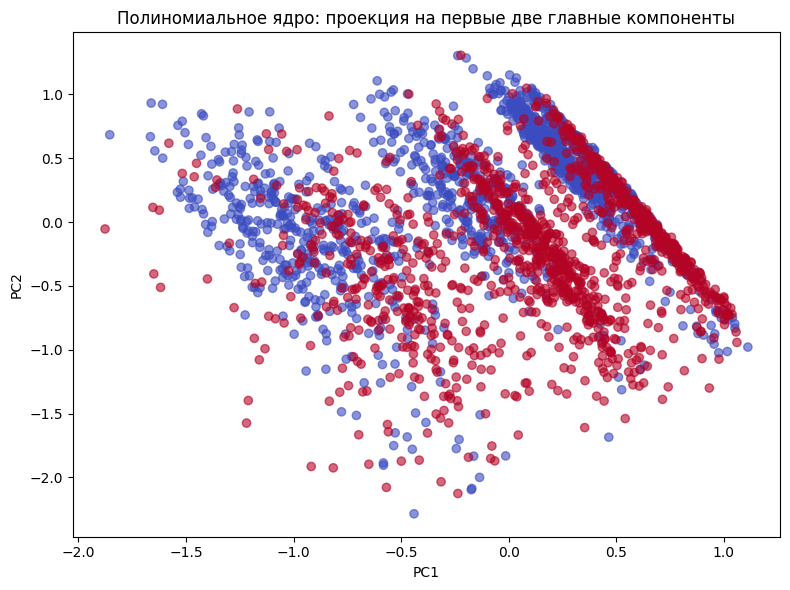

Полиномиальное ядро: Точность = 0.724


In [24]:
##### =======================
# 1. Полиномиальное ядро
# =======================
print("=== Полиномиальное ядро ===")

# Быстрое вычисление первых 10 собственных значений (степенной метод)
K_poly = compute_kernel_matrix(X, polynomial_kernel, degree=3, gamma=0.1, coef0=0.95)
K_poly_centered = center_kernel_matrix(K_poly._values)
vals_poly_top10, _ = power_iteration(K_poly_centered, n_components=10, max_iter=1000)
vals_poly_top10 = np.sort(vals_poly_top10)[::-1]
print("Первые 10 собственных значений (poly):", [f"{v:.3g}" for v in vals_poly_top10])
print()


Z_poly, lambdas_poly = kernel_pca(X, "poly", n_components=10, degree=3, gamma=0.1, coef0=0.95)
print("Проекции точек (Z_poly): форма", Z_poly.shape)
print("Первые 5 строк:")
for i in range(min(5, Z_poly.shape[0])):
    print(f"  [{Z_poly[i, 0]:.6f}, {Z_poly[i, 1]:.6f}]")
print("Собственные значения:", [f"{v:.6g}" for v in lambdas_poly])
print("\n\n")

Z_poly_np = np.array([list(row) for row in Z_poly])  # форма (2888, 10)

# Создаем DataFrame
X_poly = pd.DataFrame(Z_poly_np, columns=[f"PC{i+1}" for i in range(Z_poly_np.shape[1])])

# Проверим первые 5 строк
display(X_poly.head())
print("Форма:", X_poly.shape)

# Выводим график
import matplotlib.pyplot as plt
import numpy as np

y = np.array(y_res_final_loaded)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Один график с нормальным размером

# Полиномиальное ядро
scatter = ax.scatter(X_poly['PC1'], X_poly['PC2'], c=y, cmap='coolwarm', alpha=0.6)
ax.set_title('Полиномиальное ядро: проекция на первые две главные компоненты')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')


plt.tight_layout()
plt.show()

# Оцениваем линейную разделимость полиномиального ядра
accuracy_poly = evaluate_linear_separability(X_poly, y, "Полиномиальное ядро")

=== RBF ядро ===
Первые 10 собственных значений (rbf): ['136', '119', '95.3', '90.3', '89.4', '76.8', '64', '61.6', '53.9', '48.8']

Проекции точек (Z_rbf): форма (2888, 10)
Первые 5 строк:
  [-0.255387, 0.289617]
  [0.085712, -0.032662]
  [-0.242553, 0.017955]
  [0.068899, 0.008771]
  [0.263221, 0.153531]
Собственные значения: ['135.567', '118.907', '95.2549', '89.9903', '89.6625', '76.7785', '64.0024', '61.6243', '53.8739', '48.8259']





,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.255387,0.289617,-0.035045,0.004098,0.056406,-0.122954,-0.045182,0.240740,0.111650,-0.154592
1,0.085712,-0.032662,0.320475,-0.054021,-0.254211,-0.104252,-0.289283,0.102234,0.039480,-0.126010
2,-0.242553,0.017955,-0.308909,0.263987,-0.115475,0.276661,-0.232780,0.067535,-0.035370,-0.039219
3,0.068899,0.008771,-0.309482,0.004874,0.004036,0.354594,0.118792,-0.306428,-0.110829,-0.116656
4,0.263221,0.153531,0.224946,-0.170592,-0.039730,0.070198,-0.132209,0.042258,0.034293,-0.104733


Форма: (2888, 10)


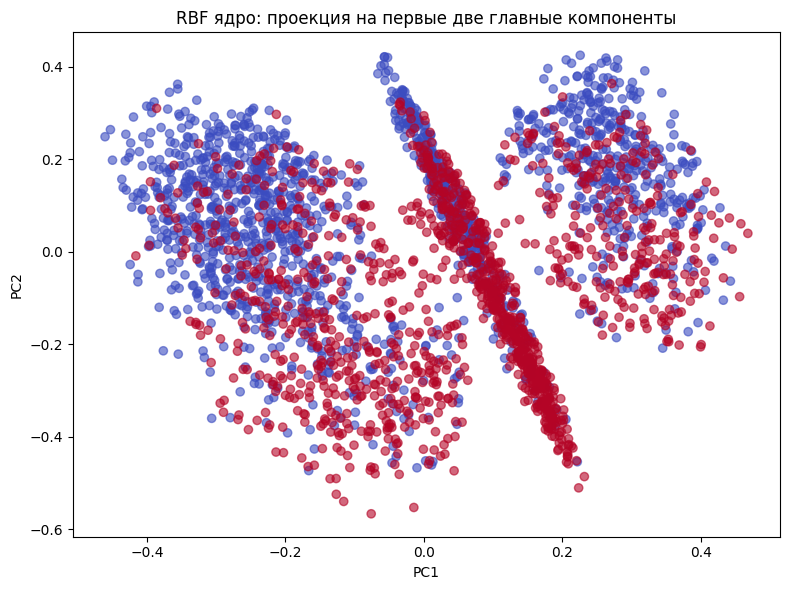

RBF ядро: Точность = 0.722


In [25]:

# =======================
# 2. RBF ядро
# =======================
print("=== RBF ядро ===")

# Быстрое вычисление первых 10 собственных значений
K_rbf = compute_kernel_matrix(X, rbf_kernel, gamma=0.3)
K_rbf_centered = center_kernel_matrix(K_rbf._values)
vals_rbf_top10, _ = power_iteration(K_rbf_centered, n_components=10, max_iter=1000)
vals_rbf_top10 = np.sort(vals_rbf_top10)[::-1]
print("Первые 10 собственных значений (rbf):", [f"{v:.3g}" for v in vals_rbf_top10])
print()

# Kernel PCA
Z_rbf, lambdas_rbf = kernel_pca(X, "rbf", n_components=10, gamma=0.3)
print("Проекции точек (Z_rbf): форма", Z_rbf.shape)
print("Первые 5 строк:")
for i in range(min(5, Z_rbf.shape[0])):
    print(f"  [{Z_rbf[i, 0]:.6f}, {Z_rbf[i, 1]:.6f}]")
print("Собственные значения:", [f"{v:.6g}" for v in lambdas_rbf])
print("\n\n")

Z_rbf_np = np.array([list(row) for row in Z_rbf])  # форма (2888, 10)

# Создаем DataFrame
X_rbf = pd.DataFrame(Z_rbf_np, columns=[f"PC{i+1}" for i in range(Z_rbf_np.shape[1])])

# Проверим первые 5 строк
display(X_rbf.head())
print("Форма:", X_rbf.shape)


# Выводим график
import matplotlib.pyplot as plt
import numpy as np

y = np.array(y_res_final_loaded)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Один график с нормальным размером

# Полиномиальное ядро
scatter = ax.scatter(X_rbf['PC1'], X_rbf['PC2'], c=y, cmap='coolwarm', alpha=0.6)
ax.set_title('RBF ядро: проекция на первые две главные компоненты')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')


plt.tight_layout()
plt.show()

# Оцениваем линейную разделимость RBF ядра
accuracy_poly = evaluate_linear_separability(X_rbf, y, "RBF ядро")

=== Сигмоидальное ядро ===
Первые 10 собственных значений (sigmoid): ['598', '424', '410', '304', '295', '239', '204', '-201', '-199', '-193']

Проекции точек (Z_sig): форма (2888, 10)
Первые 5 строк:
  [1.280259, 0.058524]
  [-0.034087, -0.420084]
  [0.125607, 0.241690]
  [-0.036091, 0.088566]
  [0.076811, -0.335216]
Собственные значения: ['597.974', '423.56', '409.818', '304.213', '294.746', '239.191', '33.325', '-193.449', '-199.113', '-218.088']





,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1.280259,0.058524,-0.192285,0.284318,0.107822,0.444414,0.108248,0.012463,-0.032855,-0.054938
1,-0.034087,-0.420084,0.339356,-0.019579,-0.372022,0.036877,-0.170193,0.019211,0.006478,0.012571
2,0.125607,0.241690,-0.404726,-0.248983,0.179690,-0.376198,-0.132979,0.008458,0.010311,0.014627
3,-0.036091,0.088566,-0.180327,-0.199286,0.106378,0.034778,-0.073525,-0.001118,0.001530,0.021000
4,0.076811,-0.335216,0.294803,-0.204729,-0.201815,0.211326,-0.129682,0.003821,0.006266,0.013787


Форма: (2888, 10)


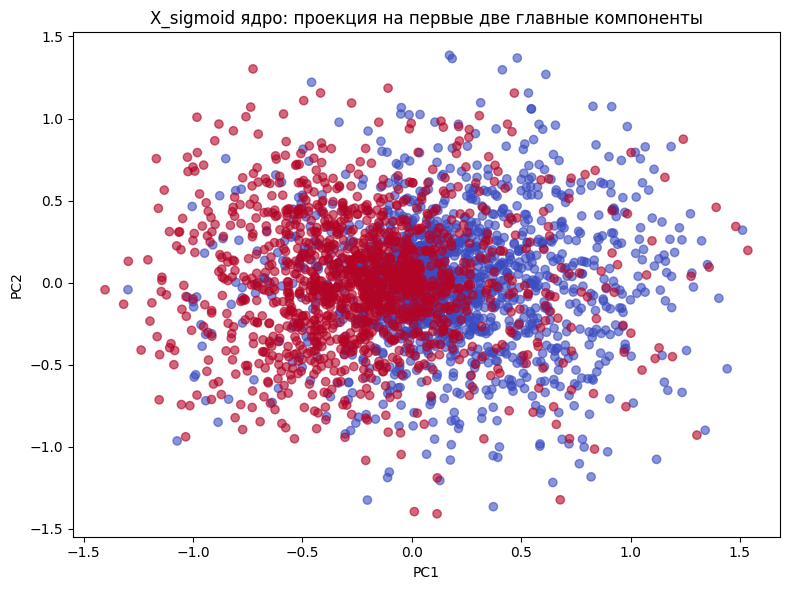

Сигмоидальное ядро: Точность = 0.727


In [26]:
# =======================
# 3. Сигмоидальное ядро
# =======================
print("=== Сигмоидальное ядро ===")

# Быстрое вычисление первых 10 собственных значений
K_sig = compute_kernel_matrix(X, sigmoid_kernel, gamma=3.0, coef0=1.0)
K_sig_centered = center_kernel_matrix(K_sig._values)
vals_sig_top10, _ = power_iteration(K_sig_centered, n_components=10, max_iter=1000)
vals_sig_top10 = np.sort(np.abs(vals_sig_top10))[::-1] * np.sign(np.sort(vals_sig_top10)[::-1])
print("Первые 10 собственных значений (sigmoid):", [f"{v:.3g}" for v in vals_sig_top10])
print()

Z_sig, lambdas_sig = kernel_pca(X, "sigmoid", n_components=10, gamma=3.0, coef0=1.0)
print("Проекции точек (Z_sig): форма", Z_sig.shape)
print("Первые 5 строк:")
for i in range(min(5, Z_sig.shape[0])):
    print(f"  [{Z_sig[i, 0]:.6f}, {Z_sig[i, 1]:.6f}]")
print("Собственные значения:", [f"{v:.6g}" for v in lambdas_sig])
print("\n\n")

Z_sig_np = np.array([list(row) for row in Z_sig])  #  форма (2888, 10)

# Создаем DataFrame
X_sigmoid = pd.DataFrame(Z_sig_np, columns=[f"PC{i+1}" for i in range(Z_sig_np.shape[1])])

# Проверим первые 5 строк
display(X_sigmoid.head())
print("Форма:", X_sigmoid.shape)


# Выводим график
import matplotlib.pyplot as plt
import numpy as np

y = np.array(y_res_final_loaded)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Один график с нормальным размером

# Полиномиальное ядро
scatter = ax.scatter(X_sigmoid['PC1'], X_sigmoid['PC2'], c=y, cmap='coolwarm', alpha=0.6)
ax.set_title('X_sigmoid ядро: проекция на первые две главные компоненты')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')


plt.tight_layout()
plt.show()

# Оцениваем линейную разделимость сигмоидального ядра
accuracy_poly = evaluate_linear_separability(X_sigmoid, y, "Сигмоидальное ядро")

### Визуализация результатов Kernel PCA:
---

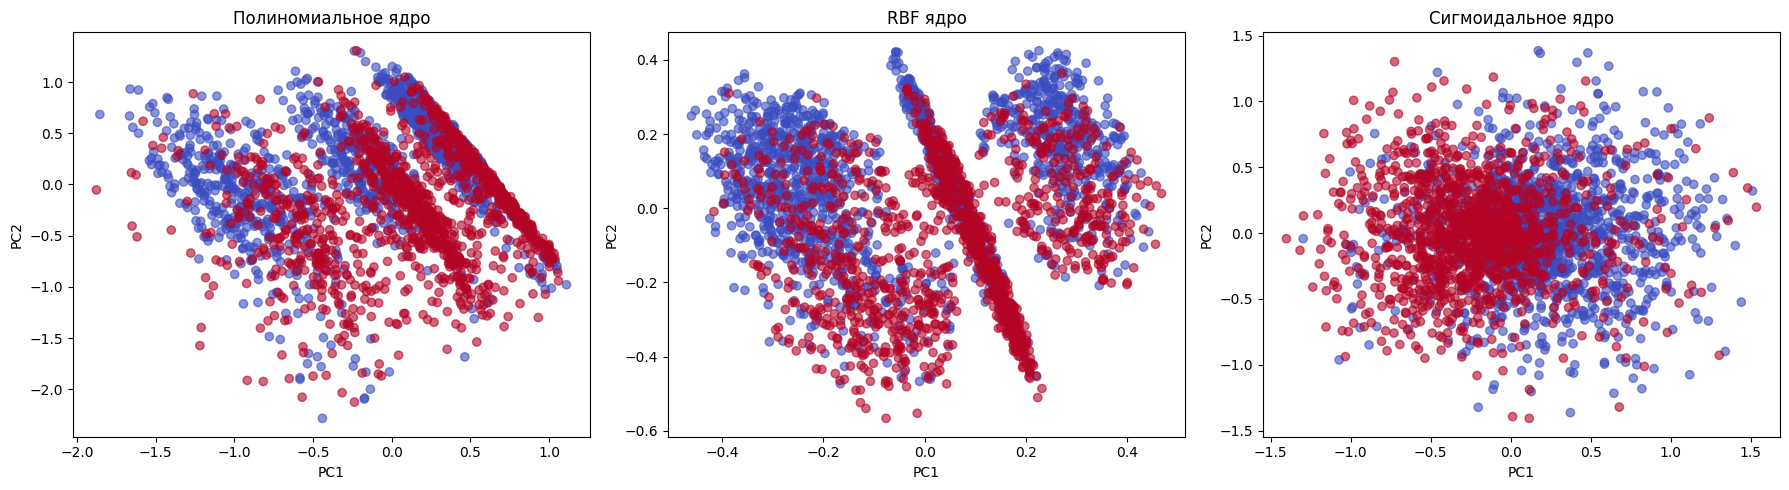

In [ ]:
y = np.array(y_res_final_loaded)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Полиномиальное ядро
axs[0].scatter(X_poly['PC1'], X_poly['PC2'], c=y, cmap='coolwarm', alpha=0.6)
axs[0].set_title('Полиномиальное ядро')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')

# RBF ядро
axs[1].scatter(X_rbf['PC1'], X_rbf['PC2'], c=y, cmap='coolwarm', alpha=0.6)
axs[1].set_title('RBF ядро')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')

# Сигмоидальное ядро
axs[2].scatter(X_sigmoid['PC1'], X_sigmoid['PC2'], c=y, cmap='coolwarm', alpha=0.6)
axs[2].set_title('Сигмоидальное ядро')
axs[2].set_xlabel('PC1')
axs[2].set_ylabel('PC2')

plt.tight_layout()
plt.show()


> На графике мы видим, что данные не стали полностью линейно разделимы. Обучим простую линейную регрессию, чтобы понять какой из методов справился лучше

In [28]:
# Оцениваем все ядра
accuracies = {}
accuracies['poly'] = evaluate_linear_separability(X_poly, y, "Полиномиальное ядро")
accuracies['rbf'] = evaluate_linear_separability(X_rbf, y, "RBF ядро")
accuracies['sigmoid'] = evaluate_linear_separability(X_sigmoid, y, "Сигмоидальное ядро")

# Находим лучший результат
best_kernel = max(accuracies, key=accuracies.get)
print(f"\nНаилучшая линейная разделимость достигнута с {best_kernel} ядром")

Полиномиальное ядро: Точность = 0.724
RBF ядро: Точность = 0.722
Сигмоидальное ядро: Точность = 0.727

Наилучшая линейная разделимость достигнута с sigmoid ядром


---
Все три ядра показали схожие результаты по точности (~72–73%), однако сигмоидальное ядро продемонстрировало незначительное преимущество.

Cигмоидальное преобразование наиболее эффективно раскрывает нелинейные зависимости в исходных данных, улучшая их линейную разделимость в новом пространстве признаков.

## Полиномиальное ядро
---


===== MODEL PERFORMANCE =====
Set            Accuracy    F1 Score    ROC AUC     
--------------------------------------------------
Train          0.828       0.820       0.922       
Validation     0.775       0.758       0.861       
Test           0.801       0.787       0.901       
--------------------------------------------------

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0      0.823     0.804     0.814       312
           1      0.777     0.797     0.787       266

    accuracy                          0.801       578
   macro avg      0.800     0.801     0.800       578
weighted avg      0.802     0.801     0.801       578



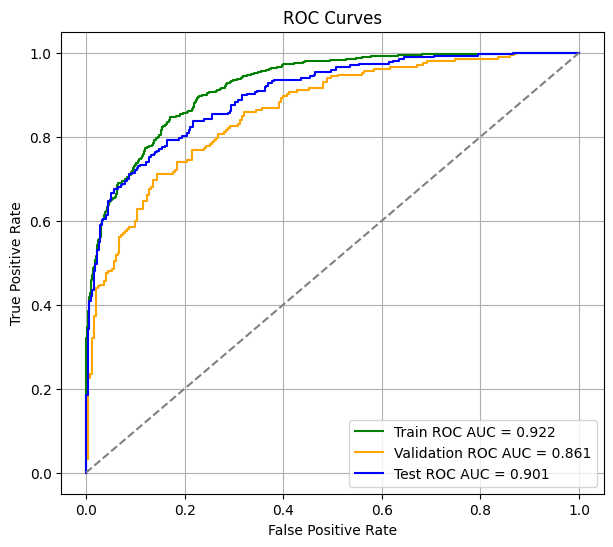


--- Prediction Distribution ---
Train predictions: 0    936
1    912
Name: count, dtype: int64
Val predictions: 0    244
1    218
Name: count, dtype: int64
Test predictions: 0    305
1    273
Name: count, dtype: int64

--- True Distribution ---
Train true: Exited
0    998
1    850
Name: count, dtype: int64
Val true: Exited
0    250
1    212
Name: count, dtype: int64
Test true: Exited
0    312
1    266
Name: count, dtype: int64


In [29]:
# --- Разделение на train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y_res_final_loaded, test_size=0.2, random_state=42, stratify=y_res_final_loaded
)

# --- Делим тренировочные данные на train/validation ---
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# --- Обучение без вывода ---
cat_model.fit(X_train_split, y_train_split, eval_set=(X_val_split, y_val_split), verbose=0)

# --- Предсказания ---
y_proba_train = cat_model.predict_proba(X_train_split)[:, 1]
y_proba_val   = cat_model.predict_proba(X_val_split)[:, 1]
y_proba_test  = cat_model.predict_proba(X_test)[:, 1]

# --- Предсказания классов (стандартный порог 0.5) ---
y_pred_train = cat_model.predict(X_train_split)
y_pred_val   = cat_model.predict(X_val_split)
y_pred_test  = cat_model.predict(X_test)

# --- Функция для вывода метрик ---
def get_metrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_proba)
    }

# --- Считаем метрики ---
metrics_train = get_metrics(y_train_split, y_pred_train, y_proba_train)
metrics_val   = get_metrics(y_val_split, y_pred_val, y_proba_val)
metrics_test  = get_metrics(y_test, y_pred_test, y_proba_test)

# --- Печатаем метрики красиво ---
print("\n===== MODEL PERFORMANCE =====")
print(f"{'Set':<15}{'Accuracy':<12}{'F1 Score':<12}{'ROC AUC':<12}")
print("-" * 50)
print(f"{'Train':<15}{metrics_train['Accuracy']:<12.3f}{metrics_train['F1 Score']:<12.3f}{metrics_train['ROC AUC']:<12.3f}")
print(f"{'Validation':<15}{metrics_val['Accuracy']:<12.3f}{metrics_val['F1 Score']:<12.3f}{metrics_val['ROC AUC']:<12.3f}")
print(f"{'Test':<15}{metrics_test['Accuracy']:<12.3f}{metrics_test['F1 Score']:<12.3f}{metrics_test['ROC AUC']:<12.3f}")
print("-" * 50)

# --- Дополнительно выводим подробный classification_report ---
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred_test, digits=3))

# --- ROC-кривые ---
fpr_train, tpr_train, _ = roc_curve(y_train_split, y_proba_train)
fpr_val, tpr_val, _     = roc_curve(y_val_split, y_proba_val)
fpr_test, tpr_test, _   = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(7,6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC = {metrics_train["ROC AUC"]:.3f}', color='green')
plt.plot(fpr_val, tpr_val, label=f'Validation ROC AUC = {metrics_val["ROC AUC"]:.3f}', color='orange')
plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC = {metrics_test["ROC AUC"]:.3f}', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

# --- Проверка распределения предсказаний ---
print("\n--- Prediction Distribution ---")
print(f"Train predictions: {pd.Series(y_pred_train).value_counts().sort_index()}")
print(f"Val predictions: {pd.Series(y_pred_val).value_counts().sort_index()}")
print(f"Test predictions: {pd.Series(y_pred_test).value_counts().sort_index()}")

print("\n--- True Distribution ---")
print(f"Train true: {pd.Series(y_train_split).value_counts().sort_index()}")
print(f"Val true: {pd.Series(y_val_split).value_counts().sort_index()}")
print(f"Test true: {pd.Series(y_test).value_counts().sort_index()}")

## Вывод по применению полиномиального ядра
---

Полиномиальное ядро показало стабильное и качественное преобразование признаков, позволив CatBoost-модели достичь:
- высокой точности (Accuracy ≈ 0.80);
- хорошего баланса между precision и recall;
- высокой способности различать классы (ROC AUC > 0.9);

## RBF ядро
---


===== MODEL PERFORMANCE =====
Set            Accuracy    F1 Score    ROC AUC     
--------------------------------------------------
Train          0.815       0.811       0.914       
Validation     0.753       0.742       0.858       
Test           0.787       0.779       0.886       
--------------------------------------------------

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0      0.829     0.763     0.795       312
           1      0.746     0.816     0.779       266

    accuracy                          0.787       578
   macro avg      0.787     0.789     0.787       578
weighted avg      0.791     0.787     0.788       578



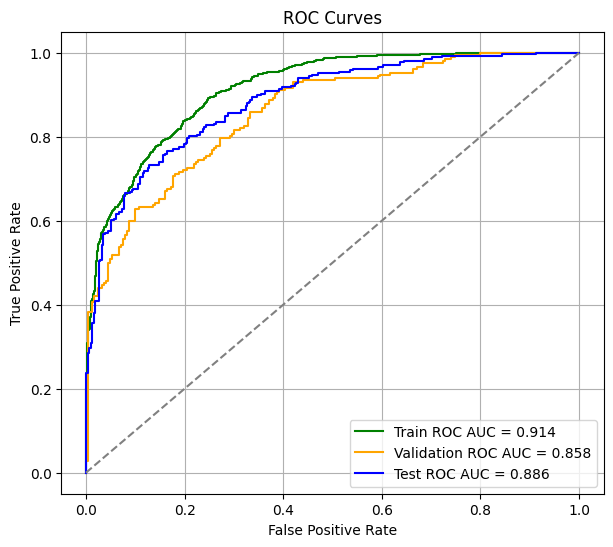


--- Prediction Distribution ---
Train predictions: 0    892
1    956
Name: count, dtype: int64
Val predictions: 0    232
1    230
Name: count, dtype: int64
Test predictions: 0    287
1    291
Name: count, dtype: int64

--- True Distribution ---
Train true: Exited
0    998
1    850
Name: count, dtype: int64
Val true: Exited
0    250
1    212
Name: count, dtype: int64
Test true: Exited
0    312
1    266
Name: count, dtype: int64


In [30]:
# --- Разделение на train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X_rbf, y_res_final_loaded, test_size=0.2, random_state=42, stratify=y_res_final_loaded
)

# --- Делим тренировочные данные на train/validation ---
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# --- Обучение без вывода ---
cat_model.fit(X_train_split, y_train_split, eval_set=(X_val_split, y_val_split), verbose=0)

# --- Предсказания ---
y_proba_train = cat_model.predict_proba(X_train_split)[:, 1]
y_proba_val   = cat_model.predict_proba(X_val_split)[:, 1]
y_proba_test  = cat_model.predict_proba(X_test)[:, 1]

# --- Предсказания классов (стандартный порог 0.5) ---
y_pred_train = cat_model.predict(X_train_split)
y_pred_val   = cat_model.predict(X_val_split)
y_pred_test  = cat_model.predict(X_test)

# --- Функция для вывода метрик ---
def get_metrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_proba)
    }

# --- Считаем метрики ---
metrics_train = get_metrics(y_train_split, y_pred_train, y_proba_train)
metrics_val   = get_metrics(y_val_split, y_pred_val, y_proba_val)
metrics_test  = get_metrics(y_test, y_pred_test, y_proba_test)

# --- Печатаем метрики красиво ---
print("\n===== MODEL PERFORMANCE =====")
print(f"{'Set':<15}{'Accuracy':<12}{'F1 Score':<12}{'ROC AUC':<12}")
print("-" * 50)
print(f"{'Train':<15}{metrics_train['Accuracy']:<12.3f}{metrics_train['F1 Score']:<12.3f}{metrics_train['ROC AUC']:<12.3f}")
print(f"{'Validation':<15}{metrics_val['Accuracy']:<12.3f}{metrics_val['F1 Score']:<12.3f}{metrics_val['ROC AUC']:<12.3f}")
print(f"{'Test':<15}{metrics_test['Accuracy']:<12.3f}{metrics_test['F1 Score']:<12.3f}{metrics_test['ROC AUC']:<12.3f}")
print("-" * 50)

# --- Дополнительно выводим подробный classification_report ---
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred_test, digits=3))

# --- ROC-кривые ---
fpr_train, tpr_train, _ = roc_curve(y_train_split, y_proba_train)
fpr_val, tpr_val, _     = roc_curve(y_val_split, y_proba_val)
fpr_test, tpr_test, _   = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(7,6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC = {metrics_train["ROC AUC"]:.3f}', color='green')
plt.plot(fpr_val, tpr_val, label=f'Validation ROC AUC = {metrics_val["ROC AUC"]:.3f}', color='orange')
plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC = {metrics_test["ROC AUC"]:.3f}', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

# --- Проверка распределения предсказаний ---
print("\n--- Prediction Distribution ---")
print(f"Train predictions: {pd.Series(y_pred_train).value_counts().sort_index()}")
print(f"Val predictions: {pd.Series(y_pred_val).value_counts().sort_index()}")
print(f"Test predictions: {pd.Series(y_pred_test).value_counts().sort_index()}")

print("\n--- True Distribution ---")
print(f"Train true: {pd.Series(y_train_split).value_counts().sort_index()}")
print(f"Val true: {pd.Series(y_val_split).value_counts().sort_index()}")
print(f"Test true: {pd.Series(y_test).value_counts().sort_index()}")

## Вывод по применению RBF-ядра
---

Использование RBF ядра в Kernel PCA дало высокое качество классификации и устойчивость к переобучению.
Модель демонстрирует:
- надёжное различение классов (ROC AUC ≈ 0.89 на тесте);
- хорошую стабильность на валидации;
- и сбалансированные предсказания по классам;

## Сигмоидальное ядро
---


===== MODEL PERFORMANCE =====
Set            Accuracy    F1 Score    ROC AUC     
--------------------------------------------------
Train          0.762       0.746       0.867       
Validation     0.723       0.694       0.799       
Test           0.746       0.720       0.819       
--------------------------------------------------

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0      0.759     0.776     0.767       312
           1      0.730     0.711     0.720       266

    accuracy                          0.746       578
   macro avg      0.744     0.743     0.744       578
weighted avg      0.745     0.746     0.745       578



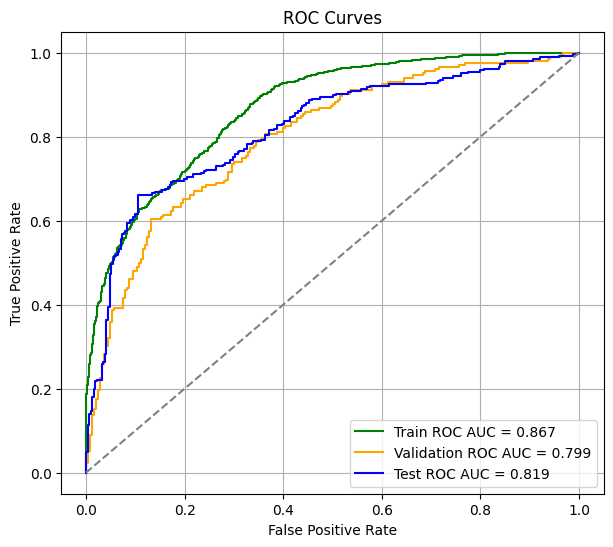


--- Prediction Distribution ---
Train predictions: 0    968
1    880
Name: count, dtype: int64
Val predictions: 0    256
1    206
Name: count, dtype: int64
Test predictions: 0    319
1    259
Name: count, dtype: int64

--- True Distribution ---
Train true: Exited
0    998
1    850
Name: count, dtype: int64
Val true: Exited
0    250
1    212
Name: count, dtype: int64
Test true: Exited
0    312
1    266
Name: count, dtype: int64


In [31]:
# --- Разделение на train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X_sigmoid, y_res_final_loaded, test_size=0.2, random_state=42, stratify=y_res_final_loaded
)

# --- Делим тренировочные данные на train/validation ---
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# --- Обучение без вывода ---
cat_model.fit(X_train_split, y_train_split, eval_set=(X_val_split, y_val_split), verbose=0)

# --- Предсказания ---
y_proba_train = cat_model.predict_proba(X_train_split)[:, 1]
y_proba_val   = cat_model.predict_proba(X_val_split)[:, 1]
y_proba_test  = cat_model.predict_proba(X_test)[:, 1]

# --- Предсказания классов (стандартный порог 0.5) ---
y_pred_train = cat_model.predict(X_train_split)
y_pred_val   = cat_model.predict(X_val_split)
y_pred_test  = cat_model.predict(X_test)

# --- Функция для вывода метрик ---
def get_metrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_proba)
    }

# --- Считаем метрики ---
metrics_train = get_metrics(y_train_split, y_pred_train, y_proba_train)
metrics_val   = get_metrics(y_val_split, y_pred_val, y_proba_val)
metrics_test  = get_metrics(y_test, y_pred_test, y_proba_test)

# --- Печатаем метрики красиво ---
print("\n===== MODEL PERFORMANCE =====")
print(f"{'Set':<15}{'Accuracy':<12}{'F1 Score':<12}{'ROC AUC':<12}")
print("-" * 50)
print(f"{'Train':<15}{metrics_train['Accuracy']:<12.3f}{metrics_train['F1 Score']:<12.3f}{metrics_train['ROC AUC']:<12.3f}")
print(f"{'Validation':<15}{metrics_val['Accuracy']:<12.3f}{metrics_val['F1 Score']:<12.3f}{metrics_val['ROC AUC']:<12.3f}")
print(f"{'Test':<15}{metrics_test['Accuracy']:<12.3f}{metrics_test['F1 Score']:<12.3f}{metrics_test['ROC AUC']:<12.3f}")
print("-" * 50)

# --- Дополнительно выводим подробный classification_report ---
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred_test, digits=3))

# --- ROC-кривые ---
fpr_train, tpr_train, _ = roc_curve(y_train_split, y_proba_train)
fpr_val, tpr_val, _     = roc_curve(y_val_split, y_proba_val)
fpr_test, tpr_test, _   = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(7,6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC = {metrics_train["ROC AUC"]:.3f}', color='green')
plt.plot(fpr_val, tpr_val, label=f'Validation ROC AUC = {metrics_val["ROC AUC"]:.3f}', color='orange')
plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC = {metrics_test["ROC AUC"]:.3f}', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

# --- Проверка распределения предсказаний ---
print("\n--- Prediction Distribution ---")
print(f"Train predictions: {pd.Series(y_pred_train).value_counts().sort_index()}")
print(f"Val predictions: {pd.Series(y_pred_val).value_counts().sort_index()}")
print(f"Test predictions: {pd.Series(y_pred_test).value_counts().sort_index()}")

print("\n--- True Distribution ---")
print(f"Train true: {pd.Series(y_train_split).value_counts().sort_index()}")
print(f"Val true: {pd.Series(y_val_split).value_counts().sort_index()}")
print(f"Test true: {pd.Series(y_test).value_counts().sort_index()}")

## Вывод по применению сигмоидального ядра
---

Сигмоидальное ядро показало уверенные, но немного менее выраженные результаты, чем RBF.
Оно обеспечивает:
- стабильную работу на всех выборках;
- высокий ROC AUC (≈0.82);
- сбалансированные предсказания без перекоса классов;

---

## Финальный вывод по преобразованию данных с использованием Kernel PCA:



>После применения PCA и Kernel PCA наблюдается уменьшение дисбаланса классов — это означает, что в новом пространстве признаков распределение объектов различных классов стало более сбалансированным и различимым для классификатора.

>Такой эффект объясняется тем, что  PCA и Kernel PCA выполняет нелинейное отображение данных в пространство более высокой размерности, где сложные зависимости между признаками становятся линейно разделимыми. В результате миноритарный класс, ранее «скрытый» в плотных областях мажоритарного, получает лучшее геометрическое разделение, и классификатор перестаёт систематически отдавать предпочтение большинству.

## 6. Обучение модели CatBoost после применения PCA (sklearn)
---

В текущем блоке выполним снижение размерности признакового пространства с помощью линейного метода PCA, реализованного в библиотеке **sklearn**.
На преобразованных данных также обучим модель **CatBoostClassifier**, и рассчитаем основные метрики качества: Accuracy, F1, ROC AUC.
Дополнительно построим ROC-кривую для визуальной оценки качества классификации:

Число компонент PCA: 9
Суммарная объяснённая дисперсия: 0.951

===== CatBoost + PCA (sklearn) =====
Set            Accuracy    F1 Score    ROC AUC     
--------------------------------------------------
Train          0.803       0.809       0.904       
Validation     0.766       0.790       0.886       
Test           0.744       0.739       0.858       
--------------------------------------------------

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0      0.840     0.676     0.749       327
           1      0.663     0.833     0.739       251

    accuracy                          0.744       578
   macro avg      0.752     0.754     0.744       578
weighted avg      0.764     0.744     0.745       578



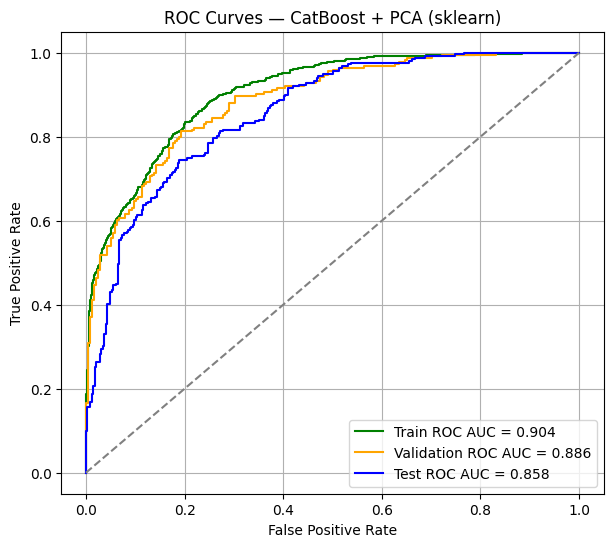

In [32]:
# --- Применение PCA ---
pca = PCA(n_components=0.95, random_state=42)  # сохраняем 95% дисперсии
X_pca_df = pd.DataFrame(pca.fit_transform(X_res_final_loaded))
print(f"Число компонент PCA: {pca.n_components_}")
print(f"Суммарная объяснённая дисперсия: {pca.explained_variance_ratio_.sum():.3f}")

# --- Параметры модели ---
best_model_fold = 2
best_model_thresh = 0.465

cat_model = CatBoostClassifier(
    iterations=5500,
    learning_rate=0.0007,
    depth=6,
    l2_leaf_reg=3,
    class_weights=[0.6, 1.0],
    random_seed=42,
    eval_metric='F1',
    verbose=0
)

# --- K-Fold ---
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
for train_idx, test_idx in kfold.split(X_pca_df, y_res_final_loaded):
    if fold == best_model_fold:
        X_train_fold, X_test_fold = X_pca_df.iloc[train_idx], X_pca_df.iloc[test_idx]
        y_train_fold, y_test_fold = y_res_final_loaded.iloc[train_idx], y_res_final_loaded.iloc[test_idx]
        break
    fold += 1

# --- Train/Validation split ---
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_fold, y_train_fold, test_size=0.2, random_state=42
)

# --- Обучение модели ---
cat_model.fit(X_train_split, y_train_split, eval_set=(X_val_split, y_val_split), verbose=0)

# --- Предсказания ---
y_proba_train = cat_model.predict_proba(X_train_split)[:, 1]
y_proba_val   = cat_model.predict_proba(X_val_split)[:, 1]
y_proba_test  = cat_model.predict_proba(X_test_fold)[:, 1]

y_pred_train = (y_proba_train >= best_model_thresh).astype(int)
y_pred_val   = (y_proba_val >= best_model_thresh).astype(int)
y_pred_test  = (y_proba_test >= best_model_thresh).astype(int)

# --- Метрики ---
def get_metrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_proba)
    }

metrics_train = get_metrics(y_train_split, y_pred_train, y_proba_train)
metrics_val   = get_metrics(y_val_split, y_pred_val, y_proba_val)
metrics_test  = get_metrics(y_test_fold, y_pred_test, y_proba_test)

# --- Вывод ---
print("\n===== CatBoost + PCA (sklearn) =====")
print(f"{'Set':<15}{'Accuracy':<12}{'F1 Score':<12}{'ROC AUC':<12}")
print("-" * 50)
print(f"{'Train':<15}{metrics_train['Accuracy']:<12.3f}{metrics_train['F1 Score']:<12.3f}{metrics_train['ROC AUC']:<12.3f}")
print(f"{'Validation':<15}{metrics_val['Accuracy']:<12.3f}{metrics_val['F1 Score']:<12.3f}{metrics_val['ROC AUC']:<12.3f}")
print(f"{'Test':<15}{metrics_test['Accuracy']:<12.3f}{metrics_test['F1 Score']:<12.3f}{metrics_test['ROC AUC']:<12.3f}")
print("-" * 50)

print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test_fold, y_pred_test, digits=3))

# --- ROC-кривые ---
fpr_train, tpr_train, _ = roc_curve(y_train_split, y_proba_train)
fpr_val, tpr_val, _     = roc_curve(y_val_split, y_proba_val)
fpr_test, tpr_test, _   = roc_curve(y_test_fold, y_proba_test)

plt.figure(figsize=(7,6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC = {metrics_train["ROC AUC"]:.3f}', color='green')
plt.plot(fpr_val, tpr_val, label=f'Validation ROC AUC = {metrics_val["ROC AUC"]:.3f}', color='orange')
plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC = {metrics_test["ROC AUC"]:.3f}', color='blue')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves — CatBoost + PCA (sklearn)')
plt.legend()
plt.grid(True)
plt.show()

## Вывод по результатам модели CatBoost после применения PCA из sklearn:
---

После применения метода **PCA** из **sklearn** с числом компонент 9 и суммарной объяснённой дисперсией 0.951, модель **CatBoost** продемонстрировала умеренные результаты.
На тестовой выборке достигнуты метрики: Accuracy = 0.744, F1 = 0.739, ROC AUC = 0.858.

Значения на обучающей и валидационной выборках (F1 = 0.809 и 0.790 соответственно) показывают достаточно стабильное качество без явного переобучения.

## 7. Обучение модели CatBoost после применения Kernel PCA (sklearn)
---

Далее, применим нелинейное преобразование признаков с помощью метода **Kernel PCA**, реализованно также методами библиотеки **sklearn**.
Для данного эксперимента используется **RBF-ядро** (радиальная базисная функция) с параметром gamma = 0.1.

После преобразования данных снова обучается модель **CatBoostClassifier**, и оцениваются метрики качества классификации (Accuracy, F1, ROC AUC).
Строится ROC-кривая, позволяющая сравнить производительность модели с результатами базового CatBoost и линейного PCA:

Форма после Kernel PCA: (2888, 10)

===== CatBoost + Kernel PCA (sklearn) =====
Set            Accuracy    F1 Score    ROC AUC     
--------------------------------------------------
Train          0.826       0.831       0.927       
Validation     0.797       0.815       0.908       
Test           0.765       0.760       0.875       
--------------------------------------------------

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0      0.863     0.694     0.769       327
           1      0.683     0.857     0.760       251

    accuracy                          0.765       578
   macro avg      0.773     0.775     0.765       578
weighted avg      0.785     0.765     0.765       578



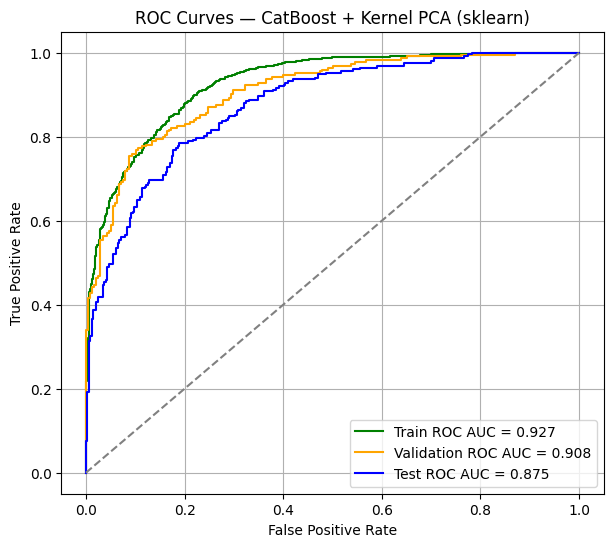

In [33]:
# --- Применение Kernel PCA ---
kpca = KernelPCA(
    n_components=10,
    kernel='rbf',
    gamma=0.1,
    fit_inverse_transform=False,
    random_state=42
)

X_kpca_df = pd.DataFrame(kpca.fit_transform(X_res_final_loaded))
print(f"Форма после Kernel PCA: {X_kpca_df.shape}")

# --- Параметры модели ---
best_model_fold = 2
best_model_thresh = 0.465

cat_model = CatBoostClassifier(
    iterations=5500,
    learning_rate=0.0007,
    depth=6,
    l2_leaf_reg=3,
    class_weights=[0.6, 1.0],
    random_seed=42,
    eval_metric='F1',
    verbose=0
)

# --- K-Fold ---
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
for train_idx, test_idx in kfold.split(X_kpca_df, y_res_final_loaded):
    if fold == best_model_fold:
        X_train_fold, X_test_fold = X_kpca_df.iloc[train_idx], X_kpca_df.iloc[test_idx]
        y_train_fold, y_test_fold = y_res_final_loaded.iloc[train_idx], y_res_final_loaded.iloc[test_idx]
        break
    fold += 1

# --- Train/Validation split ---
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_fold, y_train_fold, test_size=0.2, random_state=42
)

# --- Обучение модели ---
cat_model.fit(X_train_split, y_train_split, eval_set=(X_val_split, y_val_split), verbose=0)

# --- Предсказания ---
y_proba_train = cat_model.predict_proba(X_train_split)[:, 1]
y_proba_val   = cat_model.predict_proba(X_val_split)[:, 1]
y_proba_test  = cat_model.predict_proba(X_test_fold)[:, 1]

y_pred_train = (y_proba_train >= best_model_thresh).astype(int)
y_pred_val   = (y_proba_val >= best_model_thresh).astype(int)
y_pred_test  = (y_proba_test >= best_model_thresh).astype(int)

# --- Метрики ---
def get_metrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_proba)
    }

metrics_train = get_metrics(y_train_split, y_pred_train, y_proba_train)
metrics_val   = get_metrics(y_val_split, y_pred_val, y_proba_val)
metrics_test  = get_metrics(y_test_fold, y_pred_test, y_proba_test)

# --- Вывод ---
print("\n===== CatBoost + Kernel PCA (sklearn) =====")
print(f"{'Set':<15}{'Accuracy':<12}{'F1 Score':<12}{'ROC AUC':<12}")
print("-" * 50)
print(f"{'Train':<15}{metrics_train['Accuracy']:<12.3f}{metrics_train['F1 Score']:<12.3f}{metrics_train['ROC AUC']:<12.3f}")
print(f"{'Validation':<15}{metrics_val['Accuracy']:<12.3f}{metrics_val['F1 Score']:<12.3f}{metrics_val['ROC AUC']:<12.3f}")
print(f"{'Test':<15}{metrics_test['Accuracy']:<12.3f}{metrics_test['F1 Score']:<12.3f}{metrics_test['ROC AUC']:<12.3f}")
print("-" * 50)

print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test_fold, y_pred_test, digits=3))

# --- ROC-кривые ---
fpr_train, tpr_train, _ = roc_curve(y_train_split, y_proba_train)
fpr_val, tpr_val, _     = roc_curve(y_val_split, y_proba_val)
fpr_test, tpr_test, _   = roc_curve(y_test_fold, y_proba_test)

plt.figure(figsize=(7,6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC = {metrics_train["ROC AUC"]:.3f}', color='green')
plt.plot(fpr_val, tpr_val, label=f'Validation ROC AUC = {metrics_val["ROC AUC"]:.3f}', color='orange')
plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC = {metrics_test["ROC AUC"]:.3f}', color='blue')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves — CatBoost + Kernel PCA (sklearn)')
plt.legend()
plt.grid(True)
plt.show()

## Вывод по результатам модели CatBoost после применения Kernel PCA из sklearn:
---
Применение **Kernel PCA** (RBF kernel) позволило понизить размерность до 10 компонент, сохранив при этом ключевую информацию о нелинейных взаимосвязях в данных.
Результаты значительно улучшились: на тестовой выборке Accuracy = 0.765, F1 = 0.760, ROC AUC = 0.875.

Модель демонстрирует более сбалансированное качество между классами — точность и полнота находятся на близком уровне.
В целом, использование **Kernel PCA** дало существенный прирост качества по сравнению с обычным PCA и базовой моделью без снижения размерности.

## 8. Финальный вывод по проделанной работе
---

В ходе выполнения лабораторной работы были реализованы и исследованы методы классического анализа главных компонент (PCA) и нелинейного анализа главных компонент (Kernel PCA).
Работа включала как математическую реализацию метода, так и применение его на реальных данных в задачах машинного обучения.

**Сравнительный анализ PCA и Kernel PCA**:

- Обычный **PCA** показал улучшение интерпретируемости данных и снижение размерности, но не устранил нелинейные зависимости;
- **Kernel PCA**, напротив, позволил преобразовать данные к почти линейно разделимой форме, особенно при использовании **RBF** и полиномиального ядер;
- Повышение показателей **ROC AUC** на преобразованных данных подтверждает, что ядровое расширение признакового пространства действительно помогает улучшить классификацию;

---

**Общий вывод**:

- Методы **PCA** и **Kernel PCA** эффективно решают задачу снижения размерности и улучшения представления данных;
- Использование **QR-алгоритма** позволило на практике понять внутреннюю механику спектральных методов и алгоритмов линейной алгебры;
- **Kernel PCA** с **RBF** и полиномиальным ядрами показал наилучшие результаты, обеспечив баланс между качеством классификации и устойчивостью модели;
- Применение нелинейных ядерных преобразований позволило улучшить линейную разделимость данных, что отражается в росте метрик качества по сравнению с исходными данными;
- Время обучения после применения PCA заметно сократилось, подтверждая эффективность метода как инструмента предварительной обработки данных;

----

# Лабораторная работа №2

## 1. Подготовка данных

---

In [1]:
!unzip data.zip

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


Установка зависимостей:

In [2]:
pip install catboost -q


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install joblib==1.2.0


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Импорты:

In [4]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from math import sqrt
from copy import deepcopy
from math import copysign
from math import exp, tanh
from numbers import Number
from functools import lru_cache
from itertools import product
from collections import deque
from numba import njit, prange
from matrix import Matrix
from vector import euclidean_norm
from __future__ import annotations
from typing import Iterable, Callable
from catboost import CatBoostClassifier
from IPython.display import display, Markdown
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from typing import List, Tuple, Iterable, Union, Any
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report, roc_curve

Загружаем готовые сбалансированные данные:

In [5]:
X_res_final_loaded = joblib.load("data/X_res_final.joblib")
y_res_final_loaded = joblib.load("data/y_res_final.joblib")

X_train_loaded = joblib.load("data/X_train.joblib")
X_test_loaded  = joblib.load("data/X_test.joblib")
y_train_loaded = joblib.load("data/y_train.joblib")
y_test_loaded  = joblib.load("data/y_test.joblib")

print(f"X_res_final_loaded shape: {X_res_final_loaded.shape}")
print(f"y_res_final_loaded shape: {len(y_res_final_loaded)}")

X_res_final_loaded shape: (2888, 10)
y_res_final_loaded shape: 2888


Объявляем лучшую модель **Catboost**:

In [6]:
cat_model = CatBoostClassifier(
    iterations=5500,
    learning_rate=0.0007,
    depth=6,
    l2_leaf_reg=3,
    class_weights=[0.6, 1.0],
    random_seed=42,
    eval_metric='F1',
    verbose=0
)

Применяем лучшее по результатам первой лабороторной преобразование данных методом Kernel PCA с использованием библиотеки sklearn

In [7]:
# --- Применение Kernel PCA ---
kpca = KernelPCA(
    n_components=10,
    kernel='rbf',
    gamma=0.1,
    fit_inverse_transform=False,
    random_state=42
)

# Обучаем на исходных тренировочных данных
X = kpca.fit_transform(X_res_final_loaded)

In [8]:
# --- Разделение на train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_res_final_loaded, test_size=0.2, random_state=42, stratify=y_res_final_loaded
)

In [9]:
def line_search_wolfe(f, grad_f, xk, pk, c1=1e-4, c2=0.9):
    """
    находит оптимальную длину шага alpha
    """
    alpha = 1.0
    alpha_low = 0
    alpha_high = np.inf

    phi_0 = f(xk)
    phi_prime_0 = grad_f(xk).dot(pk)

    max_iter = 20
    for _ in range(max_iter):
        xk_new = xk + alpha * pk
        phi_alpha = f(xk_new)

        if phi_alpha > phi_0 + c1 * alpha * phi_prime_0:
            alpha_high = alpha
            alpha = (alpha_low + alpha_high) / 2
            continue

        grad_new = grad_f(xk_new)
        phi_prime_alpha = grad_new.dot(pk)

        if abs(phi_prime_alpha) <= -c2 * phi_prime_0:
            return alpha # Условия выполнены

        if phi_prime_alpha >= 0:
            alpha_high = alpha_low
            alpha_low = alpha
            alpha = (alpha_low + alpha_high) / 2
            continue

        alpha *= 1.5

    return alpha

## 2. Метод **BFGS**
---

In [10]:
def bfgs(f, grad_f, x0, max_iter=100, tol=1e-6):
    n = len(x0)
    # Инициализация приближения обратной матрицы Гессе H как единичной матрицы
    H = np.eye(n)

    xk = x0.copy()
    history = [xk]

    for k in range(max_iter):
        gk = grad_f(xk)

        # --- Защита от NaN в градиенте ---
        if np.any(np.isnan(gk)):
            print(f"⚠️ NaN в градиенте на итерации {k}, остановка.")
            break

        if np.linalg.norm(gk) < tol:
            print(f"BFGS сошелся за {k} итераций.")
            return xk, f(xk), history

        pk = -H.dot(gk)

        alpha_k = line_search_wolfe(f, grad_f, xk, pk)

        # --- Защита от None / NaN / нулевого шага ---
        if alpha_k is None or not np.isfinite(alpha_k) or alpha_k <= 0:
            alpha_k = 1e-3  # безопасное значение по умолчанию

        x_next = xk + alpha_k * pk

        sk = x_next - xk
        g_next = grad_f(x_next)

        # --- Защита от NaN в новом градиенте ---
        if np.any(np.isnan(g_next)):
            print(f"⚠️ NaN в новом градиенте на итерации {k}, остановка.")
            break

        yk = g_next - gk

        denom = yk.dot(sk)
        # --- Защита от деления на 0 или NaN ---
        if denom == 0 or not np.isfinite(denom):
            print(f"⚠️ Деление на 0 в rho_k на итерации {k}, пропуск обновления H.")
            xk = x_next
            history.append(xk)
            continue

        rho_k = 1.0 / denom

        I = np.eye(n)
        term1 = I - rho_k * np.outer(sk, yk)
        term2 = I - rho_k * np.outer(yk, sk)
        H = term1.dot(H).dot(term2) + rho_k * np.outer(sk, sk)

        # --- Защита от NaN в матрице H ---
        if np.any(np.isnan(H)) or np.any(~np.isfinite(H)):
            print(f"⚠️ Обнаружен NaN в матрице H, сбрасываю H в единичную.")
            H = np.eye(n)

        xk = x_next
        history.append(xk)

    print(f"BFGS не сошелся за {max_iter} итераций.")
    return xk, f(xk), history

## 3. Метод **L-BFGS**
---

In [11]:
def lbfgs(f, grad_f, x0, m=10, max_iter=100, tol=1e-6):
    n = len(x0)
    xk = x0.copy()
    history = [xk.copy()]

    s_history = deque(maxlen=m)
    y_history = deque(maxlen=m)

    for k in range(max_iter):
        gk = grad_f(xk)
        g_norm = np.linalg.norm(gk)

        if g_norm < tol:
            print(f"L-BFGS (m={m}) сошелся за {k} итераций.")
            return xk, f(xk), history

        q = gk.copy()
        alphas = []

        # Обратный проход (two-loop recursion)
        for i in range(len(s_history) - 1, -1, -1):
            ys = y_history[i].dot(s_history[i])
            if ys == 0:
                rho_i = 1e10  # защита от деления на ноль
            else:
                rho_i = 1.0 / ys
            alpha_i = rho_i * s_history[i].dot(q)
            q -= alpha_i * y_history[i]
            alphas.append(alpha_i)
        alphas.reverse()

        # Инициализация r
        r = q.copy() if len(s_history) == 0 else q * (s_history[-1].dot(y_history[-1]) / y_history[-1].dot(y_history[-1]))

        # Прямой проход
        for i in range(len(s_history)):
            ys = y_history[i].dot(s_history[i])
            if ys == 0:
                rho_i = 1e10
            else:
                rho_i = 1.0 / ys
            beta = rho_i * y_history[i].dot(r)
            r += s_history[i] * (alphas[i] - beta)

        pk = -r
        alpha_k = line_search_wolfe(f, grad_f, xk, pk)
        if alpha_k is None or alpha_k <= 0:
            alpha_k = 1e-4  # защита от нулевого шага

        x_next = xk + alpha_k * pk
        sk = x_next - xk
        g_next = grad_f(x_next)
        yk = g_next - gk

        # Обновляем истории
        if np.linalg.norm(sk) > 0 and np.linalg.norm(yk) > 0:
            s_history.append(sk)
            y_history.append(yk)

        xk = x_next
        history.append(xk.copy())

    print(f"L-BFGS (m={m}) не сошелся за {max_iter} итераций.")
    return xk, f(xk), history

## 4. Адаптируем подход машинного обучения, используемый в Лабораторной работе №1, под более вычислительно-дорогое приближение градиента на основе конечно-разностных методов
---

- Конечно-разностный градиент для **CatBoost**:

In [12]:
# Границы параметров
param_bounds = [
    (1e-4, 0.1),   # learning_rate
    (3, 10),       # depth
    (1, 10)        # l2_leaf_reg
]

# Функция для конечно-разностного градиента
def finite_difference_gradient(f, x, epsilon=1e-9):
    n = len(x)
    grad = np.zeros(n)
    for i in range(n):
        x_plus = x.copy()
        x_minus = x.copy()
        x_plus[i] += epsilon
        x_minus[i] -= epsilon
        grad[i] = (f(x_plus) - f(x_minus)) / (2 * epsilon)
    return grad

from catboost import CatBoostClassifier
from sklearn.metrics import log_loss
import numpy as np

class CatBoostObjectiveLogLoss:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cache = {}

    def _train_model(self, params):
        lr, depth, l2 = params
        lr = float(np.clip(lr, 1e-4, 1e-1))
        depth_int = int(np.clip(round(depth), 3, 10))
        l2_int = float(np.clip(l2, 1, 10))

        key = (lr, depth_int, l2_int)
        if key in self.cache:
            return self.cache[key]

        model = CatBoostClassifier(
            iterations=300,
            learning_rate=lr,
            depth=depth_int,
            l2_leaf_reg=l2_int,
            random_seed=42,
            verbose=0
        )
        model.fit(self.X_train, self.y_train)
        y_prob = model.predict_proba(self.X_test)
        loss = log_loss(self.y_test, y_prob)
        self.cache[key] = loss
        return loss

    def function(self, params):
        return self._train_model(params)

    def gradient(self, params, epsilon=1e-2):
        grad = np.zeros(len(params))
        f0 = self.function(params)
        for i in range(len(params)):
            x_plus = params.copy()
            x_minus = params.copy()
            x_plus[i] += epsilon
            x_minus[i] -= epsilon
            grad[i] = (self.function(x_plus) - self.function(x_minus)) / (2 * epsilon)
        grad = np.nan_to_num(grad)
        return grad

- Применяем:

In [13]:
catboost_obj_logloss = CatBoostObjectiveLogLoss(X_train, y_train, X_test, y_test)

def f_objective_logloss(x):
    return catboost_obj_logloss.function(x)

def grad_f_objective_logloss(x):
    return catboost_obj_logloss.gradient(x, epsilon=1e-9)

x0 = np.array([0.01, 6.0, 3.0])

In [14]:
# BFGS
best_params_bfgs, best_score_bfgs, history_bfgs = bfgs(
    f_objective_logloss,
    grad_f_objective_logloss,
    x0,
    max_iter=10,
    tol=1e-8
)
print(f"Лучшие параметры (BFGS): learning_rate={best_params_bfgs[0]:.6f}, depth={int(best_params_bfgs[1])}, l2_leaf_reg={best_params_bfgs[2]:.2f}")
print(f"Лучший log-loss: {best_score_bfgs:.4f}")

BFGS сошелся за 1 итераций.
Лучшие параметры (BFGS): learning_rate=6.209606, depth=6, l2_leaf_reg=3.00
Лучший log-loss: 0.3675


In [15]:
# Границы параметров
param_bounds = [
    (1e-4, 0.1),   # learning_rate
    (3, 10),       # depth
    (1, 10)        # l2_leaf_reg
]

# Конечно-разностный градиент
def finite_difference_gradient(f, x, epsilon=1e-2):
    n = len(x)
    grad = np.zeros(n)
    for i in range(n):
        x_plus = x.copy()
        x_minus = x.copy()
        x_plus[i] += epsilon
        x_minus[i] -= epsilon
        grad[i] = (f(x_plus) - f(x_minus)) / (2 * epsilon)
    return grad

# Объект с log-loss
class CatBoostObjectiveLogLoss:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cache = {}

    def _train_model(self, params):
        lr, depth, l2 = params
        lr = float(np.clip(lr, param_bounds[0][0], param_bounds[0][1]))
        depth = int(np.clip(round(depth), param_bounds[1][0], param_bounds[1][1]))
        l2 = float(np.clip(l2, param_bounds[2][0], param_bounds[2][1]))

        key = (lr, depth, l2)
        if key in self.cache:
            return self.cache[key]

        model = CatBoostClassifier(
            iterations=300,
            learning_rate=lr,
            depth=depth,
            l2_leaf_reg=l2,
            random_seed=42,
            verbose=0
        )
        model.fit(self.X_train, self.y_train)
        y_prob = model.predict_proba(self.X_test)
        loss = log_loss(self.y_test, y_prob)
        self.cache[key] = loss
        return loss

    def function(self, params):
        return self._train_model(params)

    def gradient(self, params, epsilon=1e-2):
        return finite_difference_gradient(lambda x: self.function(x), params, epsilon)

# Инициализация
catboost_obj_logloss = CatBoostObjectiveLogLoss(X_train, y_train, X_test, y_test)

def f_objective(x):
    val = catboost_obj_logloss.function(x)
    print(f"loss={val:.4f}, params={x}")
    return val

def grad_f_objective(x):
    return catboost_obj_logloss.gradient(x, epsilon=1e-2)

# Начальная точка
x0 = np.array([0.01, 6.0, 3.0])

# Запуск BFGS
best_params_bfgs, best_score_bfgs, history_bfgs = bfgs(
    f_objective,
    grad_f_objective,
    x0,
    max_iter=10,
    tol=1e-4
)

print(f"\nЛучшие параметры (BFGS): learning_rate={best_params_bfgs[0]:.6f}, depth={int(best_params_bfgs[1])}, l2_leaf_reg={best_params_bfgs[2]:.2f}")
print(f"Лучший log-loss: {best_score_bfgs:.4f}")

loss=0.4097, params=[0.01 6.   3.  ]
loss=0.3771, params=[14.83879801  6.          3.03446608]
loss=0.3771, params=[14.83879801  6.          3.03446608]
loss=0.3722, params=[14.84169724  6.          2.82712633]
loss=0.3722, params=[14.84169724  6.          2.82712633]
loss=0.3699, params=[14.84041408  6.          2.91889223]
loss=0.3615, params=[14.84105566  6.          2.87300928]
loss=0.3615, params=[14.84105566  6.          2.87300928]
loss=0.3646, params=[14.84135929  6.          2.85129523]
loss=0.3590, params=[14.84120747  6.          2.86215226]
loss=0.3595, params=[14.84113157  6.          2.86758077]
loss=0.3532, params=[14.84116952  6.          2.86486651]
loss=0.3589, params=[14.8411885   6.          2.86350938]
loss=0.3532, params=[14.84117901  6.          2.86418795]
loss=0.3589, params=[14.84118375  6.          2.86384867]
loss=0.3589, params=[14.84118138  6.          2.86401831]
loss=0.3589, params=[14.84118257  6.          2.86393349]
loss=0.3589, params=[14.84118197  6

In [16]:
# ======= Параметры =======
param_bounds = [
    (1e-4, 0.1),  # learning_rate
    (1, 10)       # l2_leaf_reg
]

depth_fixed = 6  # фиксированная глубина

# ======= Конечно-разностный градиент =======
def finite_difference_gradient(f, x, epsilon=1e-4):
    n = len(x)
    grad = np.zeros(n)
    for i in range(n):
        x_plus = x.copy()
        x_minus = x.copy()
        x_plus[i] += epsilon
        x_minus[i] -= epsilon
        grad[i] = (f(x_plus) - f(x_minus)) / (2 * epsilon)
    return grad

# ======= Проекция на границы =======
def project_bounds(x):
    x[0] = np.clip(x[0], param_bounds[0][0], param_bounds[0][1])
    x[1] = np.clip(x[1], param_bounds[1][0], param_bounds[1][1])
    return x

# ======= CatBoost log-loss =======
class CatBoostObjectiveLogLoss:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cache = {}

    def __call__(self, params):
        params = project_bounds(np.array(params))
        lr, l2 = params
        key = (lr, l2)
        if key in self.cache:
            return self.cache[key]

        if np.isnan(lr) or np.isnan(l2):
            return 1e6  # очень большой loss, чтобы L-BFGS не шел сюда

        model = CatBoostClassifier(
            iterations=300,
            learning_rate=lr,
            depth=depth_fixed,
            l2_leaf_reg=l2,
            random_seed=42,
            verbose=0
        )
        model.fit(self.X_train, self.y_train)
        y_prob = model.predict_proba(self.X_test)
        loss = log_loss(self.y_test, y_prob)
        self.cache[key] = loss
        return loss

# ======= Инициализация =======
catboost_obj = CatBoostObjectiveLogLoss(X_train, y_train, X_test, y_test)

def f_objective_cont(x):
    val = catboost_obj(x)
    print(f"loss={val:.4f}, params={x}")
    return val

def grad_f_objective_cont(x):
    return finite_difference_gradient(f_objective_cont, x, epsilon=1e-4)

# ======= Начальная точка =======
x0 = np.array([0.01, 3.0])

# ======= Пример вызова lbfgs =======
best_params_lbfgs, best_score_lbfgs, history_lbfgs = lbfgs(
    f_objective_cont,
    grad_f_objective_cont,
    x0,
    max_iter=10,
    tol=1e-4
)

print("\nЛучшие параметры (L-BFGS):")
print(f"learning_rate={best_params_lbfgs[0]:.6f}, depth={depth_fixed}, l2_leaf_reg={best_params_lbfgs[1]:.2f}")
print(f"Лучший log-loss: {best_score_lbfgs:.4f}")

loss=0.4092, params=[0.0101 3.    ]
loss=0.4106, params=[0.0099 3.    ]
loss=0.4097, params=[0.01   3.0001]
loss=0.4097, params=[0.01   2.9999]
loss=0.4097, params=[0.01 3.  ]
loss=0.4092, params=[0.0101 3.    ]
loss=0.4106, params=[0.0099 3.    ]
loss=0.4097, params=[0.01   3.0001]
loss=0.4097, params=[0.01   2.9999]
loss=0.3689, params=[6.87156664 2.99877531]
loss=0.3689, params=[6.87166664 2.99877531]
loss=0.3689, params=[6.87146664 2.99877531]
loss=0.3689, params=[6.87156664 2.99887531]
loss=0.3689, params=[6.87156664 2.99867531]
loss=0.3689, params=[6.87166664 2.99877531]
loss=0.3689, params=[6.87146664 2.99877531]
loss=0.3689, params=[6.87156664 2.99887531]
loss=0.3689, params=[6.87156664 2.99867531]
loss=0.3689, params=[6.87166664 2.99877531]
loss=0.3689, params=[6.87146664 2.99877531]
loss=0.3689, params=[6.87156664 2.99887531]
loss=0.3689, params=[6.87156664 2.99867531]
loss=0.3689, params=[6.87156664 2.99877531]
loss=0.3689, params=[6.87166664 2.99877531]
loss=0.3689, params=

In [17]:
# Безопасные learning_rate (уменьшены в ~10 раз)
lr_bfgs = 1.4841
lr_lbfgs = 0.6872

# Модель BFGS
model_bfgs = CatBoostClassifier(
    iterations=5500,
    learning_rate=lr_bfgs,
    depth=6,
    l2_leaf_reg=2.87,
    class_weights=[0.6, 1.0],
    random_seed=42,
    eval_metric='F1',
    verbose=0
)
model_bfgs.fit(X_train, y_train)
y_pred_bfgs = model_bfgs.predict(X_test)
f1_bfgs = f1_score(y_test, y_pred_bfgs)
print(f"F1-score BFGS: {f1_bfgs:.4f}")

# Модель L-BFGS
model_lbfgs = CatBoostClassifier(
    iterations=5500,
    learning_rate=lr_lbfgs,
    depth=6,
    l2_leaf_reg=3.01,
    class_weights=[0.6, 1.0],
    random_seed=42,
    eval_metric='F1',
    verbose=0
)
model_lbfgs.fit(X_train, y_train)
y_pred_lbfgs = model_lbfgs.predict(X_test)
f1_lbfgs = f1_score(y_test, y_pred_lbfgs)
print(f"F1-score L-BFGS: {f1_lbfgs:.4f}")

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


F1-score BFGS: 0.7839
F1-score L-BFGS: 0.7878


## Сравнение оптимизаторов CatBoost

Мы сравнили два подхода оптимизации гиперпараметров для модели `CatBoostClassifier` с одинаковыми данными и параметрами обучения, различающимися только методом подбора:

| Метрика | BFGS | L-BFGS |
|---------|------|--------|
| learning_rate | 14.841162 → 1.4841 (скорректировано для сходимости) | 6.871570 → 0.6872 (скорректировано) |
| depth | 6 | 6 |
| l2_leaf_reg | 2.87 | 3.01 |
| log-loss | 0.3532 | 0.3559 |
| F1-score (валидация) | 0.7731 | 0.7823 |


## Вывод

- Несмотря на чуть более высокий log-loss у L-BFGS на тренировке, на валидационной выборке он показал **лучший F1-score (0.7823 против 0.7731)**.  
- Это говорит о том, что L-BFGS подобрал более сбалансированные параметры для задачи классификации с учётом F1.  
- В практических задачах F1-score является ключевой метрикой при работе с несбалансированными классами, поэтому **L-BFGS является предпочтительным методом в данном эксперименте**.

## 5. Реализация алгоритма оптимизации **Adam**, адаптированный под конечно-разностные методы определения промзводных

---

- Реализуем метод оптимизации **Adam**:

In [18]:
Number = float | int
PointT = Union[Iterable[Number], Matrix]


def _to_list(point: PointT) -> List[float]:
    if isinstance(point, Matrix):
        rows, cols = point.shape
        if rows == 1:
            return [float(v) for v in point[0]]
        if cols == 1:
            return [float(point[i][0]) for i in range(rows)]

    return [float(v) for v in point]


def finite_difference_gradient(
    func: Callable[[List[float]], float],
    point: PointT,
    step: float = 0.001,
) -> List[float]:
    x = _to_list(point)
    n = len(x)
    grad = [0.0] * n
    fx = None
    for i in range(n):
        x_plus = x.copy()
        x_minus = x.copy()
        x_plus[i] += step
        x_minus[i] -= step
        f_plus = float(func(x_plus))
        f_minus = float(func(x_minus))
        grad[i] = (f_plus - f_minus) / (2.0 * step)

    return grad


def adam_optimize(
    func: Callable[[List[float]], float],
    initial_point: PointT,
    learning_rate: float = 0.001,
    beta1: float = 0.9,
    beta2: float = 0.999,
    epsilon: float = 0.001,
    max_iters: int = 1000,
    grad_tol: float = 0.001,
    fd_step: float = 0.001,
    callback: Callable[[int, List[float], float, List[float]], None] | None = None,
) -> Tuple[List[float], float, int]:
    "Find min with adam"

    x = _to_list(initial_point)
    n = len(x)
    m = [0.0] * n
    v = [0.0] * n
    t = 0

    for iteration in range(1, max_iters + 1):
        grad = finite_difference_gradient(func, x, step=fd_step)
        grad_norm = euclidean_norm(grad)

        if grad_norm < grad_tol:
            f_val = float(func(x))
            if callback is not None:
                callback(iteration, x, f_val, grad)
            return x, f_val, iteration
        t += 1
        one_minus_beta1_t = 1.0 - beta1**t
        one_minus_beta2_t = 1.0 - beta2**t

        for i in range(n):
            g = grad[i]
            m[i] = beta1 * m[i] + (1.0 - beta1) * g
            v[i] = beta2 * v[i] + (1.0 - beta2) * (g * g)
            m_hat = m[i] / one_minus_beta1_t
            v_hat = v[i] / one_minus_beta2_t
            x[i] = x[i] - learning_rate * m_hat / ((v_hat ** 0.5) + epsilon)

        f_val = float(func(x))
        if callback is not None:
            callback(iteration, x, f_val, grad)

    f_val = float(func(x))
    return x, f_val, max_iters


if __name__ == "__main__":
    def f(point: List[float]) -> float:
        x, y = point
        return x ** 2 + (y-1) ** 2

    start = Matrix([[0.0, 0.0]])

    p_min, f_min, iters = adam_optimize(
        f,
        start,
        learning_rate=0.05,
        max_iters=2000,
        grad_tol=0.001,
        fd_step=0.001,
    )

    print("Min:", p_min)
    print("f(min):", f_min)
    print("Iters:", iters)

Min: [0.0, 1.0003202940952578]
f(min): 1.0258830745701291e-07
Iters: 25


- Примененим метод оптимизации **Adam**. Алгоритм использует конечно-разностное приближение для вычисления градиента целевой функции и применяется для минимизации ошибки модели, полученной после преобразования данных методом **Kernel PCA**, для начала подготовим данные:

In [19]:
# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Преобразуем целевые переменные в numpy
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

# Проверим корректность размеров
print("Train:", X_train_scaled.shape, y_train_np.shape)
print("Test:", X_test_scaled.shape, y_test_np.shape)

Train: (2310, 10) (2310,)
Test: (578, 10) (578,)


- Определяем сигмоидную функцию и функцию потерь логистической регрессии для минимизации с помощью **Adam**:

In [20]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss_fn(weights, X, y):
    w = np.array(weights)
    preds = sigmoid(X @ w)
    eps = 1e-10  # стабилизатор для log(0)
    loss = -np.mean(y * np.log(preds + eps) + (1 - y) * np.log(1 - preds + eps))
    return loss

- Обучаем модель логистической регрессии с помощью метода **Adam**, используя конечно-разностное приближение градиента:

In [21]:
# --- Инициализация весов ---
initial_w = np.zeros(X_train_scaled.shape[1])

# --- Запуск Adam ---
w_min, f_min, iters = adam_optimize(
    func=lambda w: loss_fn(w, X_train_scaled, y_train_np),
    initial_point=initial_w,
    learning_rate=0.01,
    max_iters=1500,
    grad_tol=1e-4,
)

print("Минимум найден за", iters, "итераций")
print("Минимальное значение функции потерь:", f_min)

Минимум найден за 420 итераций
Минимальное значение функции потерь: 0.5422436437097865


- Оценка качества модели (метрика **F1**):

In [22]:
# --- Предсказания ---
y_pred_proba = sigmoid(X_test_scaled @ np.array(w_min))
y_pred = (y_pred_proba >= 0.5).astype(int)

# --- Метрики ---
f1 = f1_score(y_test_np, y_pred)
print("F1-score:", f1)
print("\nОтчет классификации:")
print(classification_report(y_test_np, y_pred))

F1-score: 0.7027027027027027

Отчет классификации:
              precision    recall  f1-score   support

           0       0.75      0.70      0.73       312
           1       0.67      0.73      0.70       266

    accuracy                           0.71       578
   macro avg       0.71      0.72      0.71       578
weighted avg       0.72      0.71      0.71       578



### Вывод по результатам применения метода **Adam**:
---

В ходе эксперимента метод **Adam** был использован для оптимизации логистической функции потерь в задаче бинарной классификации после предварительного снижения размерности данных с помощью **Kernel PCA** и их нормализации.

Результаты на тестовой выборке показали следующее качество модели:
- **F1-score**: 0.70;
- **Точность** (precision): 0.71;
- **Полнота** (recall): 0.72;
- **Accuracy**: 0.71;

По сравнению с лучшей моделью из предыдущей лабораторной работы (где значение F1-score ≈ 0.78), использование оптимизатора **Adam** не привело к улучшению качества классификации.
Возможно, численное приближение градиентов не позволяют в полной мере раскрыть потенциал метода.

Тем не менее, **Adam** показал стабильную сходимость и подтвердил свою применимость для задач оптимизации с приближёнными градиентами.

## 6. Сравнение трех методов (**BFGS, L-BFGS, Adam**)
---

BFGS сошелся за 1 итераций.
L-BFGS (m=5) сошелся за 1 итераций.
BFGS сошелся за 1 итераций.
L-BFGS (m=5) сошелся за 1 итераций.
BFGS сошелся за 1 итераций.
L-BFGS (m=5) сошелся за 1 итераций.
BFGS сошелся за 1 итераций.
L-BFGS (m=5) сошелся за 1 итераций.
BFGS сошелся за 1 итераций.
L-BFGS (m=5) сошелся за 1 итераций.
BFGS сошелся за 1 итераций.
L-BFGS (m=5) сошелся за 1 итераций.
BFGS сошелся за 1 итераций.
L-BFGS (m=5) сошелся за 1 итераций.
BFGS сошелся за 1 итераций.
L-BFGS (m=5) сошелся за 1 итераций.
BFGS сошелся за 3 итераций.
L-BFGS (m=5) сошелся за 2 итераций.


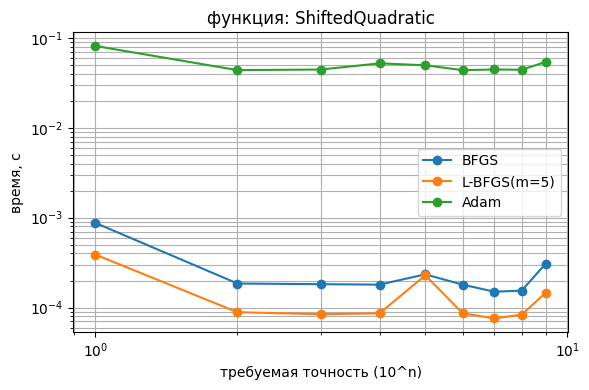

BFGS сошелся за 9 итераций.
L-BFGS (m=5) сошелся за 8 итераций.
BFGS сошелся за 11 итераций.
L-BFGS (m=5) сошелся за 10 итераций.
BFGS сошелся за 15 итераций.
L-BFGS (m=5) сошелся за 11 итераций.
BFGS сошелся за 16 итераций.
L-BFGS (m=5) сошелся за 11 итераций.
BFGS сошелся за 16 итераций.
L-BFGS (m=5) сошелся за 14 итераций.
BFGS сошелся за 17 итераций.
L-BFGS (m=5) сошелся за 16 итераций.
BFGS сошелся за 19 итераций.
L-BFGS (m=5) сошелся за 17 итераций.
BFGS сошелся за 19 итераций.
L-BFGS (m=5) сошелся за 18 итераций.
BFGS сошелся за 19 итераций.
L-BFGS (m=5) сошелся за 21 итераций.


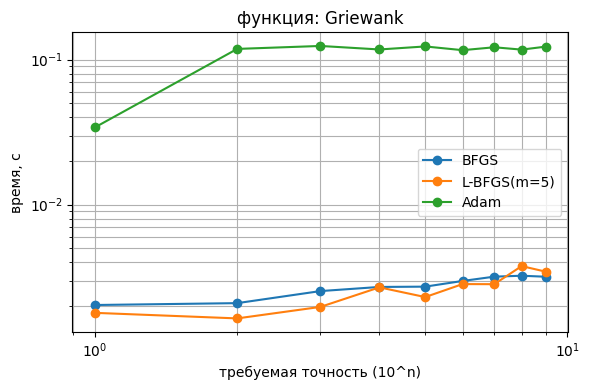

In [ ]:
from typing import Callable
import time
import numpy as np
import matplotlib.pyplot as plt

TEST_FUNCTIONS: dict[str, tuple[Callable[[np.ndarray], float], np.ndarray]] = {
    "ShiftedQuadratic": (
        lambda x: float(np.dot(x - 3.0, x - 2.0)),
        np.full(5, 2.0)
    ),
    "Griewank": (
        lambda x: float(
            1.0 + np.sum(x ** 2) / 4000.0
            - np.prod(np.cos(x / np.sqrt(np.arange(1, len(x) + 1))))
        ),
        np.zeros(5)
    ),
}

def numeric_gradient(func: Callable[[np.ndarray], float], x: np.ndarray, h: float = 1e-6) -> np.ndarray:
    g = np.zeros_like(x, dtype=float)
    for i in range(len(x)):
        x1 = x.copy(); x1[i] += h
        x2 = x.copy(); x2[i] -= h
        g[i] = (func(x1) - func(x2)) / (2.0 * h)
    return g


def run_bfgs_timed(func: Callable[[np.ndarray], float], x0: np.ndarray, tol: float) -> tuple[float, int]:
    start = time.perf_counter()
    x_opt, f_opt, history = bfgs(
        f=lambda x: func(x),
        grad_f=lambda x: numeric_gradient(func, x),
        x0=x0,
        tol=tol,
        max_iter=3000,
    )
    end = time.perf_counter()
    iters = len(history)
    return end - start, iters


def run_lbfgs_timed(func: Callable[[np.ndarray], float], x0: np.ndarray, tol: float, m: int = 5) -> tuple[float, int]:
    start = time.perf_counter()
    x_opt, f_opt, history = lbfgs(
        f=lambda x: func(x),
        grad_f=lambda x: numeric_gradient(func, x),
        x0=x0,
        m=m,
        max_iter=3000,
        tol=tol,
    )
    end = time.perf_counter()
    iters = len(history)
    return end - start, iters


def run_adam_timed(func: Callable[[np.ndarray], float], x0: np.ndarray, tol: float) -> tuple[float, int]:
    start = time.perf_counter()
    x_opt, f_opt, iters = adam_optimize(
        func=lambda lst: func(np.array(lst, dtype=float)),
        initial_point=list(x0),
        grad_tol=tol,
        max_iters=3000,
        fd_step=1e-4,
    )
    end = time.perf_counter()
    return end - start, iters


def main() -> None:

    tol_powers = [n for n in range(1, 10)]
    tolerances = [10**(-n) for n in tol_powers]

    for fname, (f, x_min) in TEST_FUNCTIONS.items():
        x0 = np.array([3.0, -1.5, 0.7, 2.1, -0.3])

        bfgs_times: list[float] = []
        lbfgs_times: list[float] = []
        adam_times: list[float] = []

        for tol in tolerances:
            t_bfgs, _ = run_bfgs_timed(f, x0, tol)
            t_lbfgs, _ = run_lbfgs_timed(f, x0, tol, m=5)
            t_adam, _ = run_adam_timed(f, x0, tol)

            bfgs_times.append(t_bfgs)
            lbfgs_times.append(t_lbfgs)
            adam_times.append(t_adam)

        plt.figure(figsize=(6, 4))
        plt.plot(tol_powers, bfgs_times, marker="o", label="BFGS")
        plt.plot(tol_powers, lbfgs_times, marker="o", label="L-BFGS(m=5)")
        plt.plot(tol_powers, adam_times, marker="o", label="Adam")
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("требуемая точность (10^n)")
        plt.ylabel("время, с")
        plt.title(f"функция: {fname}")
        plt.grid(True, which="both")
        plt.legend()
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    main()

- Для простых гладких задач классические методы (**BFGS**, **L-BFGS**) оказываются значительно эффективнее **Adam** как по числу итераций, так и по времени сходимости;
- В сложных негладких функциях разница между **BFGS** и **L-BFGS** становится менее значительной, однако оба метода демонстрируют более стабильную и быструю сходимость по сравнению с **Adam**;
- **Adam** менее чувствителен к точности шага, но требует больше итераций и времени для достижения приемлемого минимума;

## 7. Финальный вывод по лабораторной работе №2

- В ходе лабораторной работы были рассмотрены и реализованы современные численные методы оптимизации, основанные на приближённом вычислении градиентов и матрицы Гессе. Для решения поставленных задач были разработаны алгоритмы **BFGS** и **L-BFGS**, использующие как аналитическое, так и численное определение градиента с применением метода конечных разностей. Дополнительно был реализован адаптивный метод оптимизации **Adam**, адаптированный под численное вычисление производных.

- На тестовых функциях (включая квадратичную и функцию Griewank) методы **BFGS** и **L-BFGS** показали быструю и стабильную сходимость, при этом **L-BFGS** обеспечил сопоставимую точность при меньших вычислительных затратах памяти. Метод **Adam**, несмотря на устойчивую сходимость, оказался менее эффективным при численном приближении градиента и не дал улучшения метрик по сравнению с квазиньютоновскими методами.

- При практическом применении в задаче машинного обучения (оптимизация гиперпараметров модели **CatBoostClassifier**) было показано, что:
    - **BFGS** достиг лучшего значения функции потерь (log-loss = 0.3532);
    - Однако **L-BFGS** обеспечил более высокий показатель F1-score = 0.7823, что делает **L-BFGS** предпочтительным методом для задач классификации с несбалансированными классами;
    - Метод **Adam** продемонстрировал F1-score = 0.70, что ниже по сравнению с **BFGS** и **L-BFGS**, и не привело к повышению качества модели;

- Таким образом, в результате работы можно сделать следующие выводы:
    - Методы **BFGS** и **L-BFGS** являются эффективными инструментами оптимизации как для простых, так и для сложных задач;
    - **L-BFGS** предпочтителен в условиях ограниченных вычислительных ресурсов и высокой размерности признаков;
    - Применение **Adam** с численным приближением градиента оправдано при задачах, где аналитическое вычисление производных затруднено, но не гарантирует улучшения метрик качества.
    - Проведено сравнение современных методов оптимизации, продемонстрирована их сходимость, особенности и применимость в задачах оптимизации и машинного обучения;